<a href="https://colab.research.google.com/github/chakraa1/DSML/blob/master/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)
from prophet import Prophet   # from fbprophet import Prophet

# 2. Set Options

In [ ]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option("display.max_columns",None)
pd.options.display.float_format='{:.2f}'.format
sns.set_style('white')
plt.rcParams['figure.figsize'] = (20,8)

page_map = {
        "en":"English",
        "ja":"Japanese",
        "de":"German",
        "fr":"French",
        "zh":"Chinese",
        "ru":"Russian",
        "es":"Spanish",
    }

# 3. Problem Statement

- **Forecasting the number of views** so that organization can predict and **optimize the ad placement** for the clients
- **Forecusting** views **by region**
- **Forecasting** views **by page title** 
- **Forecasting** views **by season**
- **Allow bidding** on popular **pages and seasons**

# 4. Read Data & Data Formatting

## 4.1 Read Time Series

In [ ]:
df = pd.read_csv('./drive/MyDrive/train_1.csv')
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider       18.00       11.00   
1             2PM_zh.wikipedia.org_all-access_spider       11.00       14.00   
2              3C_zh.wikipedia.org_all-access_spider        1.00        0.00   
3         4minute_zh.wikipedia.org_all-access_spider       35.00       13.00   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0        5.00       13.00       14.00        9.00        9.00       22.00   
1       15.00       18.00       11.00       13.00       22.00       11.00   
2        1.00        1.00        0.00        4.00        0.00        3.00   
3       10.00       94.00        4.00       26.00       14.00        9.00   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  2015-07-10  2015-07-11  2015-07-12  2015-07-13  2015-07-14  \
0       26.00       24.00       19.00       10.00       14.00       15.00   
1       10.00        4.00       41.00       65.00       57.00       38.00   
2        4.00        4.00        1.00        1.00        1.00        6.00   
3       11.00       16.00       16.00       11.00       23.00      145.00   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-15  2015-07-16  2015-07-17  2015-07-18  2015-07-19  2015-07-20  \
0        8.00       16.00        8.00        8.00       16.00        7.00   
1       20.00       62.00       44.00       15.00       10.00       47.00   
2        8.00        6.00        4.00        5.00        1.00        2.00   
3       14.00       17.00       85.00        4.00       30.00       22.00   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-21  2015-07-22  2015-07-23  2015-07-24  2015-07-25  2015-07-26  \
0       11.00       10.00       20.00       18.00       15.00       14.00   
1       24.00       17.00       22.00        9.00       39.00       13.00   
2        3.00        8.00        8.00        6.00        6.00        2.00   
3        9.00       10.00       11.00        7.00        7.00       11.00   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-27  2015-07-28  2015-07-29  2015-07-30  2015-07-31  2015-08-01  \
0       49.00       10.00       16.00       18.00        8.00        5.00   
1       11.00       12.00       21.00       19.00        9.00       15.00   
2        2.00        3.00        2.00        4.00        3.00        3.00   
3        9.00       11.00       44.00        8.00       14.00       19.00   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-08-02  2015-08-03  2015-08-04  2015-08-05  2015-08-06  2015-08-07  \
0        9.00        7.00       13.00        9.00        7.00        4.00   
1       33.00        8.00        8.00        7.00       13.00        2.00   
2        5.00        3.00        5.00        4.00        2.00        5.00   
3       10.00       17.00       17.00       10.00        7.00       10.00   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-08-08  2015-08-09  2015-08-10  2015-08-11  2015-08-12  2015-08-13  \
0       11.00       10.00        5.00        9.00        9.00        9.00   
1       23.00       12.00       27.00       27.00       36.00       23.00   
2        1.00        4.00        5.00        0.00        0.00        7.00   
3        1.00        8.00       27.00       19.00       16.00        2.00   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-08-14  2015-08-15  2015-08-16  2015-08-17  2015-08-18  2015-08-19  \
0        9.00       13.00        4.00       15.00       25.00        9.00   
1       58.00       80.00       60.00       69.00       42.00      161.00   
2        3.00        5.00        1.00        6.00        2.00        5.00   
3       84.00     

 ### 4.1.1 Time Series - Data Shape

In [ ]:
df.shape

(145063, 551)

### 4.1.2 Time Series - Data Types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## 4.2 Read Exogenous Data

In [ ]:
exog_df = pd.read_csv('./drive/MyDrive/Exog_Campaign_eng')
exog_df.head()

Exog
0     0
1     0
2     0
3     0
4     0

# 5. Data Pre-processing - Tranformation & Cleanup

## 5.1 Extract - Page language

In [ ]:
# The page name contains data in this format: SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
df[["page_name","page_lang","access_type","access_origin"]]=df.Page.str.extract(pat = '(\S+)\_([a-z]{2}).wikipedia.org_(\S+)\_(\S+)')
df[["Page","page_name","page_lang","access_type","access_origin"]].head()

Page         page_name  \
0            2NE1_zh.wikipedia.org_all-access_spider              2NE1   
1             2PM_zh.wikipedia.org_all-access_spider               2PM   
2              3C_zh.wikipedia.org_all-access_spider                3C   
3         4minute_zh.wikipedia.org_all-access_spider           4minute   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  52_Hz_I_Love_You   

  page_lang access_type access_origin  
0        zh  all-access        spider  
1        zh  all-access        spider  
2        zh  all-access        spider  
3        zh  all-access        spider  
4        zh  all-access        spider

In [ ]:
df["page_lang"].value_counts(normalize=True)*100

en   18.95
ja   16.06
de   14.58
fr   13.99
zh   13.54
ru   11.81
es   11.06
Name: page_lang, dtype: float64

## 5.2 Check Missing values 

In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({
    'feature_name': df.columns,
    'percent_missing': percent_missing
})
missing_value_df.sort_values('percent_missing', ascending=False)

feature_name  percent_missing
2015-07-02   2015-07-02            14.35
2015-07-01   2015-07-01            14.30
2015-07-07   2015-07-07            14.24
2015-07-05   2015-07-05            14.24
2015-07-04   2015-07-04            14.24
...                 ...              ...
2016-12-31   2016-12-31             2.39
2016-12-20   2016-12-20             2.25
2016-12-21   2016-12-21             2.23
2016-12-24   2016-12-24             2.20
Page               Page             0.00

[555 rows x 2 columns]

### 5.2.1 Understanding the reason of missing values

- **Observation**
  -  the time series is quarterly data , no day , month wise granular series available 

# 6. Feature Engineering

## 6.1 Basic Feature Engineering 

### 6.1.1 Mean , Median Page Visits

#### 6.1.1.1 Data Processing formatting  - II

In [ ]:
# Flatenning data - Converting columns to rows by date
# Note - for smooth processing , only last 1 year data i.e. df.columns[-200:] has been considered 
df_flattened = pd.melt(df[list(df.columns[-200:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
# Passing errors='coerce' will force an out-of-bounds date to NaT, in addition to forcing non-dates (or non-parseable dates) to NaT.
df_flattened['date'] = pd.to_datetime(df_flattened['date'], errors='coerce')
# Filling missing Views by zero visits 
df_flattened['Visits'].fillna(0)
# Removing missing date as there are enough samples available and percentage of missing dates are just 0.72 %
df_flattened = df_flattened.dropna()
df_flattened.head()

Page       date Visits
0            2NE1_zh.wikipedia.org_all-access_spider 2016-06-19   8.00
1             2PM_zh.wikipedia.org_all-access_spider 2016-06-19  10.00
2              3C_zh.wikipedia.org_all-access_spider 2016-06-19   6.00
3         4minute_zh.wikipedia.org_all-access_spider 2016-06-19  27.00
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s... 2016-06-19   4.00

#### 6.1.1.2 Post formatting missing value check

In [ ]:
percent_missing = df_flattened.isnull().sum() * 100 / len(df_flattened)
missing_value_df = pd.DataFrame({
    'feature_name': df_flattened.columns,
    'percent_missing': percent_missing
})
missing_value_df.sort_values('percent_missing', ascending=False)

feature_name  percent_missing
Page           Page             0.00
date           date             0.00
Visits       Visits             0.00

#### 6.1.1.3 Median feature

In [ ]:
# Median by page
df_median = pd.DataFrame(df_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median_views']
df_median.head()

median_views
Page                                                            
!vote_en.wikipedia.org_all-access_all-agents                3.00
!vote_en.wikipedia.org_all-access_spider                    1.50
!vote_en.wikipedia.org_desktop_all-agents                   3.00
"Awaken,_My_Love!"_en.wikipedia.org_all-access_...       6213.00
"Awaken,_My_Love!"_en.wikipedia.org_all-access_...         61.00

#### 6.1.1.4 Max feature

In [ ]:
# Max by page
df_max = pd.DataFrame(df_flattened.groupby(['Page'])['Visits'].max())
df_max.columns = ['max_views']
#df_flattened = df_flattened.set_index('Page').join(df_max)
#df.drop(df_max.index, inplace=True)
df_max.head()

max_views
Page                                                         
!vote_en.wikipedia.org_all-access_all-agents            15.00
!vote_en.wikipedia.org_all-access_spider                 7.00
!vote_en.wikipedia.org_desktop_all-agents               14.00
"Awaken,_My_Love!"_en.wikipedia.org_all-access_...   57917.00
"Awaken,_My_Love!"_en.wikipedia.org_all-access_...     893.00

#### 6.1.1.5 Mean feature

In [ ]:
# Average by page
df_mean = pd.DataFrame(df_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean_views']
#df_flattened = df_flattened.set_index('Page').join(df_mean)
#df.drop(df_mean.index, inplace=True)
df_mean.head()

mean_views
Page                                                          
!vote_en.wikipedia.org_all-access_all-agents              3.52
!vote_en.wikipedia.org_all-access_spider                  1.75
!vote_en.wikipedia.org_desktop_all-agents                 3.19
"Awaken,_My_Love!"_en.wikipedia.org_all-access_...     8959.83
"Awaken,_My_Love!"_en.wikipedia.org_all-access_...      107.75

#### 6.1.1.6 Mergring new features

In [ ]:
# Merging data
df_flattened = df_flattened.set_index('Page').join(df_mean).join(df_max).join(df_median)
df_mean.drop(df_mean.index, inplace=True)
df_max.drop(df_max.index, inplace=True)
df_median.drop(df_median.index, inplace=True)

In [ ]:
df_flattened.head()

date Visits  mean_views  \
Page                                                                         
!vote_en.wikipedia.org_all-access_all-agents 2016-06-19   5.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-20   5.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-21   4.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-22   2.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-23   6.00        3.52   

                                              max_views  median_views  
Page                                                                   
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00  
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00  
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00  
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00  
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00

### 6.1.2 Day , Week , Weekend , Rolling Average 

#### 6.1.2.1 Weekend

In [ ]:
df_flattened['weekend'] = ((df_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

#### 6.1.2.2 Day

In [ ]:
df_flattened['day']=df_flattened.date.dt.day

#### 6.1.2.3 Month

In [ ]:
df_flattened['month']=df_flattened.date.dt.month 

#### 6.1.2.4 Day of the week

In [ ]:
df_flattened['day_of_week']=df_flattened.date.dt.day_of_week 

#### 6.1.2.5 Year

In [ ]:
df_flattened['year']=df_flattened.date.dt.year 

In [ ]:
df_flattened.head()

date Visits  mean_views  \
Page                                                                         
!vote_en.wikipedia.org_all-access_all-agents 2016-06-19   5.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-20   5.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-21   4.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-22   2.00        3.52   
!vote_en.wikipedia.org_all-access_all-agents 2016-06-23   6.00        3.52   

                                              max_views  median_views  \
Page                                                                    
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00   
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00   
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00   
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00   
!vote_en.wikipedia.org_all-access_all-agents      15.00          3.00   

                                              weekend  day  month  \
Page                                                                
!vote_en.wikipedia.org_all-access_all-agents     1.00   19      6   
!vote_en.wikipedia.org_all-access_all-agents     0.00   20      6   
!vote_en.wikipedia.org_all-access_all-agents     0.00   21      6   
!vote_en.wikipedia.org_all-access_all-agents     0.00   22      6   
!vote_en.wikipedia.org_all-access_all-agents     0.00   23      6   

                                              day_of_week  year  
Page                                                             
!vote_en.wikipedia.org_all-access_all-agents            6  2016  
!vote_en.wikipedia.org_all-access_all-agents            0  2016  
!vote_en.wikipedia.org_all-access_all-agents            1  2016  
!vote_en.wikipedia.org_all-access_all-agents            2  2016  
!vote_en.wikipedia.org_all-access_all-agents            3  2016

In [ ]:
# df_flattened[["page_name","page_lang","access_type","access_origin"]]=df_flattened.index.str.extract(pat = '(\S+)\_([a-z]{2}).wikipedia.org_(\S+)\_(\S+)')
# can't use this as it's crashing on flatten data 

## 6.2 Feature Engineering - II

### 6.2.1 Cumulative page visits by Page language

In [ ]:
df_agg = df.groupby("page_lang").sum()

In [ ]:
df_agg.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  \
page_lang                                                               
de        13260519.00 13079896.00 12554042.00 11520379.00 13392347.00   
en        84712190.00 84438545.00 80167728.00 83463204.00 86198637.00   
es        15278553.00 14601013.00 13427632.00 12606538.00 13710356.00   
fr         8458638.00  8512952.00  8186030.00  8749842.00  8590493.00   
ja        11863200.00 13620792.00 12305383.00 15456239.00 14827204.00   

           2015-07-06  2015-07-07  2015-07-08  2015-07-09  2015-07-10  \
page_lang                                                               
de        14741758.00 14296292.00 14505194.00 13964778.00 13014478.00   
en        92809436.00 87838054.00 82880196.00 84798911.00 84319456.00   
es        15625554.00 15230654.00 14781870.00 14502906.00 13184481.00   
fr         8949799.00  8650800.00  8491533.00  8403646.00  7930703.00   
ja        12920547.00 12568828.00 12492787.00 12178258.00 12652904.00   

           2015-07-11  2015-07-12  2015-07-13  2015-07-14  2015-07-15  \
page_lang                                                               
de        12039840.00 14283405.00 15585142.00 14832386.00 13843895.00   
en        84789145.00 93278944.00 92391925.00 92916217.00 85897445.00   
es        11857475.00 13509710.00 15326284.00 16095299.00 15211173.00   
fr         7859445.00  8975294.00  8752235.00  9386520.00  8660422.00   
ja        13067202.00 14058184.00 12516153.00 11725545.00 11750729.00   

           2015-07-16  2015-07-17  2015-07-18  2015-07-19  2015-07-20  \
page_lang                                                               
de        13711470.00 14112152.00 16604612.00 15676325.00 14365031.00   
en        86911142.00 83305889.00 80407564.00 85355761.00 89703489.00   
es        14484346.00 13035566.00 11341826.00 12131662.00 14251441.00   
fr         8468700.00  8152034.00  8252003.00  8946482.00  8724524.00   
ja        13442675.00 16092006.00 13531709.00 13269080.00 13272401.00   

           2015-07-21  2015-07-22  2015-07-23  2015-07-24  2015-07-25  \
page_lang                                                               
de        13396644.00 13667443.00 13277034.00 12591499.00 12516571.00   
en        85445391.00 84101656.00 82834983.00 80528579.00 80688873.00   
es        14116786.00 14526984.00 13629881.00 12106405.00 10848312.00   
fr         8496967.00  8550221.00  8054199.00  7540250.00  7556389.00   
ja        11597690.00 11636921.00 11055890.00 10058961.00  9804021.00   

           2015-07-26  2015-07-27  2015-07-28   2015-07-29  2015-07-30  \
page_lang                                                                
de        13082340.00 14006159.00 13894680.00  13859144.00 13246985.00   
en        86443049.00 87839022.00 86547068.00 100997661.00 79149841.00   
es        11964151.00 13779529.00 13677200.00  13830691.00 13154842.00   
fr         8198930.00  7948325.00  7850067.00   7962474.00  7601774.00   
ja        10497147.00 10144099.00  9915773.00  10797521.00  9741595.00   

           2015-07-31  2015-08-01  2015-08-02  2015-08-03  2015-08-04  \
page_lang                                                               
de        12407566.00 12151836.00 12570110.00 13070656.00 13843595.00   
en        76561328.00 76694933.00 83480430.00 78772201.00 84914255.00   
es        11884813.00 10379963.00 11393967.00 11742768.00 14244393.00   
fr         7140903.00  6915625.00  7057658.00  7199333.00  8652499.00   
ja         9129558.00  8862033.00  9886225.00 10681343.00 12343649.00   

           2015-08-05  2015-08-06  2015-08-07  2015-08-08  2015-08-09  \
page_lang                                                               
de        13255691.00 13349733.00 13620276.00 12314296.00 13736848.00   
en        85031361.00 85193175.00 86786167.00 82792852.00 86316308.00   
es        14415776.00 14427191.00 12819279.00 11793780.00 12895478.00   
fr         8348533.00  8505003.00  8603320.00  8694116.

#### 6.2.1.1 Transposing data

In [ ]:
ts = df_agg.T
ts.head()

page_lang           de          en          es         fr          ja  \
2015-07-01 13260519.00 84712190.00 15278553.00 8458638.00 11863200.00   
2015-07-02 13079896.00 84438545.00 14601013.00 8512952.00 13620792.00   
2015-07-03 12554042.00 80167728.00 13427632.00 8186030.00 12305383.00   
2015-07-04 11520379.00 83463204.00 12606538.00 8749842.00 15456239.00   
2015-07-05 13392347.00 86198637.00 13710356.00 8590493.00 14827204.00   

page_lang          ru         zh  
2015-07-01 9463854.00 4144988.00  
2015-07-02 9627643.00 4151189.00  
2015-07-03 8923463.00 4123659.00  
2015-07-04 8393214.00 4163448.00  
2015-07-05 8938528.00 4441286.00

#### 6.2.1.2 Setting index as date

In [ ]:
ts.index = pd.to_datetime(ts.index)
ts

page_lang           de           en          es          fr          ja  \
2015-07-01 13260519.00  84712190.00 15278553.00  8458638.00 11863200.00   
2015-07-02 13079896.00  84438545.00 14601013.00  8512952.00 13620792.00   
2015-07-03 12554042.00  80167728.00 13427632.00  8186030.00 12305383.00   
2015-07-04 11520379.00  83463204.00 12606538.00  8749842.00 15456239.00   
2015-07-05 13392347.00  86198637.00 13710356.00  8590493.00 14827204.00   
...                ...          ...         ...         ...         ...   
2016-12-27 20125264.00 145628731.00 15945353.00 15281470.00 16123301.00   
2016-12-28 19152389.00 141278366.00 16577375.00 13781521.00 16150715.00   
2016-12-29 18447906.00 150557534.00 15647135.00 13399796.00 17682688.00   
2016-12-30 17606030.00 125404585.00 11560095.00 12471074.00 19450687.00   
2016-12-31 16562720.00 123623809.00 11077924.00 11504691.00 24460799.00   

page_lang           ru         zh  
2015-07-01  9463854.00 4144988.00  
2015-07-02  9627643.00 4151189.00  
2015-07-03  8923463.00 4123659.00  
2015-07-04  8393214.00 4163448.00  
2015-07-05  8938528.00 4441286.00  
...                ...        ...  
2016-12-27 15040168.00 6478442.00  
2016-12-28 14000319.00 6513400.00  
2016-12-29 13478977.00 6042545.00  
2016-12-30 12066750.00 6111203.00  
2016-12-31 13223033.00 6298565.00  

[550 rows x 7 columns]

#### 6.2.1.3  Resampling - Quarterly to monthly forecast

Since we are looking at time series data, there may arise situations where we wish to manipulate the time frame of our data (seconds, days, months, years). 
**In this case we would like to forecast monthly , instead of quarterly**

Resampling means sampling the existing data according to our requirement, by either upsampling or downsampling.


- In practice, there are 2 main reasons why using resample.

  - To inspect how data behaves differently under different resolutions or frequency.
  - To join datasets/tables with different resolutions.

In [ ]:
ts.resample('M').sum().head()

page_lang            de            en           es           fr           ja  \
2015-07-31 425330006.00 2657721329.00 423713933.00 258002594.00 377991002.00   
2015-08-31 421194870.00 2602760459.00 467254349.00 269245711.00 412538815.00   
2015-09-30 443851904.00 2573337031.00 554161474.00 306138231.00 403274706.00   
2015-10-31 464007939.00 2839072442.00 579900362.00 324461957.00 409479728.00   
2015-11-30 504375877.00 2790248888.00 539331006.00 347732118.00 396079417.00   

page_lang            ru           zh  
2015-07-31 300354049.00 131114851.00  
2015-08-31 329903387.00 138451793.00  
2015-09-30 381033169.00 128888257.00  
2015-10-31 403644385.00 142804687.00  
2015-11-30 433362616.00 148996400.00

#### 6.2.1.4 Post Aggregation missing value check

In [ ]:
percent_missing = df_agg.isnull().sum() * 100 / len(df_agg)
missing_value_df = pd.DataFrame({
    'feature_name': df_agg.columns,
    'percent_missing': percent_missing
})
missing_value_df.sort_values('percent_missing', ascending=False)

feature_name  percent_missing
2015-07-01   2015-07-01             0.00
2016-07-04   2016-07-04             0.00
2016-06-28   2016-06-28             0.00
2016-06-29   2016-06-29             0.00
2016-06-30   2016-06-30             0.00
...                 ...              ...
2015-12-25   2015-12-25             0.00
2015-12-24   2015-12-24             0.00
2015-12-23   2015-12-23             0.00
2015-12-22   2015-12-22             0.00
2016-12-31   2016-12-31             0.00

[550 rows x 2 columns]

# 7. Exploratory Data Analysis

- Exploratory Data Analysis (20 points)
    - Separating the data
    - Analyzing and visualizing the data
    - Getting inferences

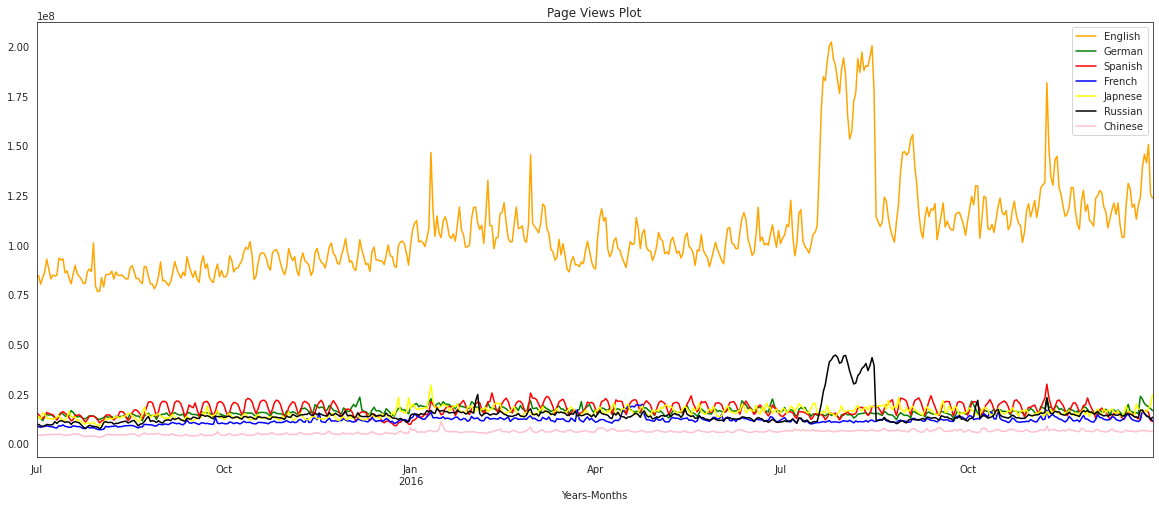

In [ ]:
# Visualizing views of all the pages in different language
  
# using plot method to plot page views.
# in plot method we set the label and color of the curve.
ts['en'].plot(label='English', color='orange')
ts['de'].plot(label='German', color='green')
ts['es'].plot(label='Spanish', color='red')
ts['fr'].plot(label='French', color='blue')
ts['ja'].plot(label='Japnese', color='yellow')
ts['ru'].plot(label='Russian', color='black')
ts['zh'].plot(label='Chinese', color='pink')
# adding title to the plot
plt.title('Page Views Plot')
  
# adding Label to the x-axis
plt.xlabel('Years-Months')
  
# adding legend to the curve
plt.legend()

## 7.1 English page Time Series

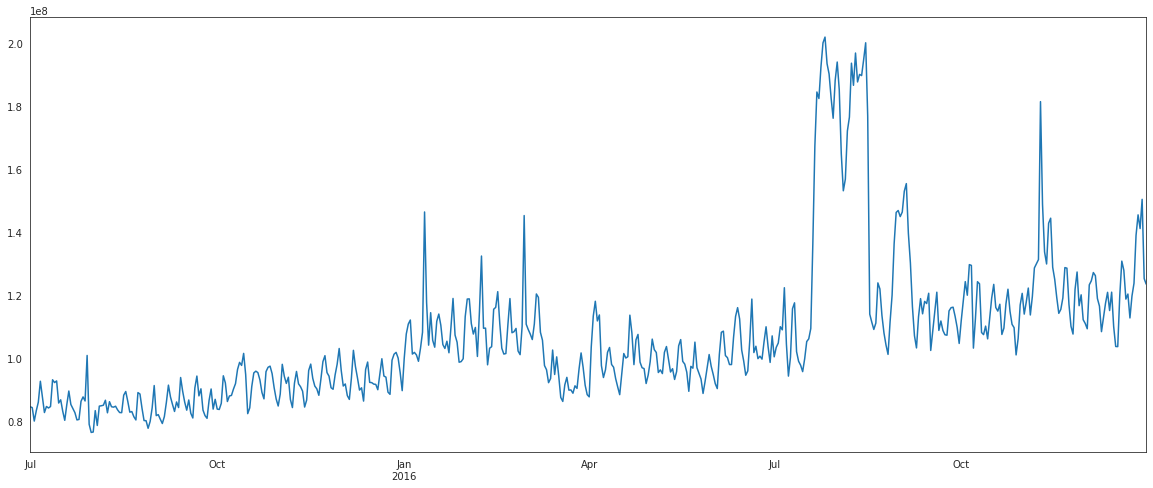

In [ ]:
ts.en.plot()

- **Observation**
  -  There is no **missing** value in the time series
  -  It's quarterly data i.e. **period = 3** , which will be useful for decomposition
  -  The magnitude of the seasonal component changes with time, hence the series is **multiplicative**

## 7.2 Japnese page Time Series

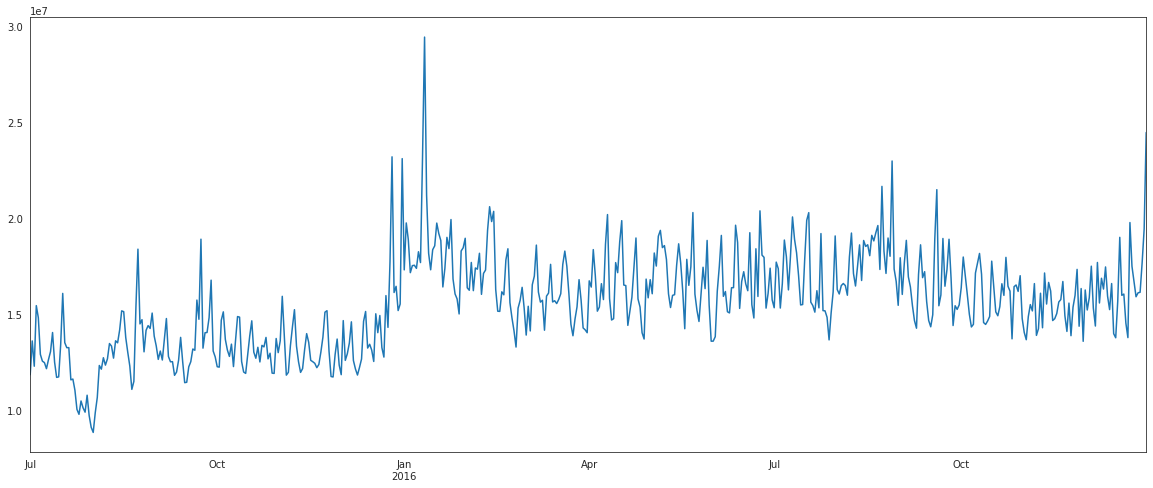

In [ ]:
ts.ja.plot()

## 7.3 Chinese page Time Series

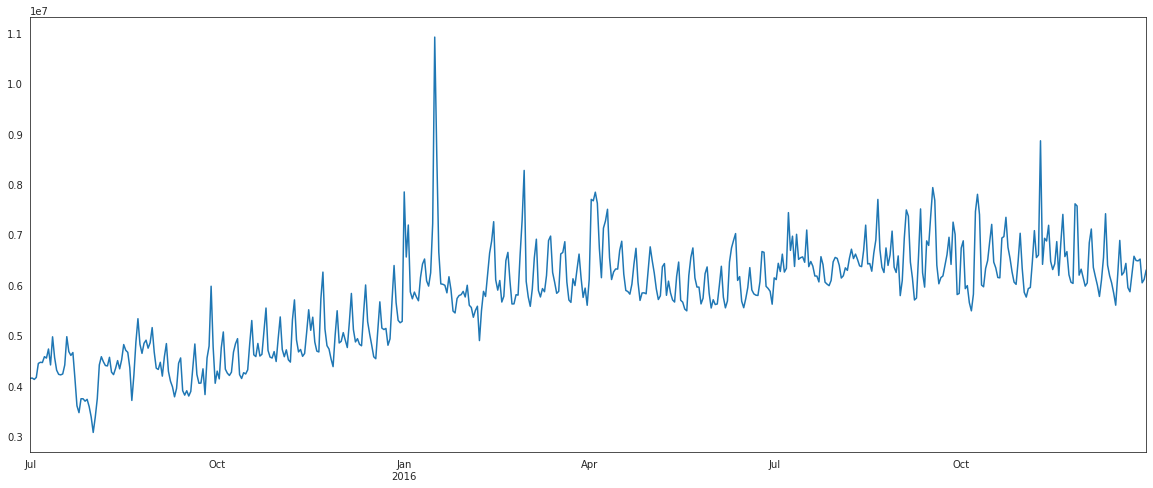

In [ ]:
ts.zh.plot()

## 7.4 Russian page Time Series

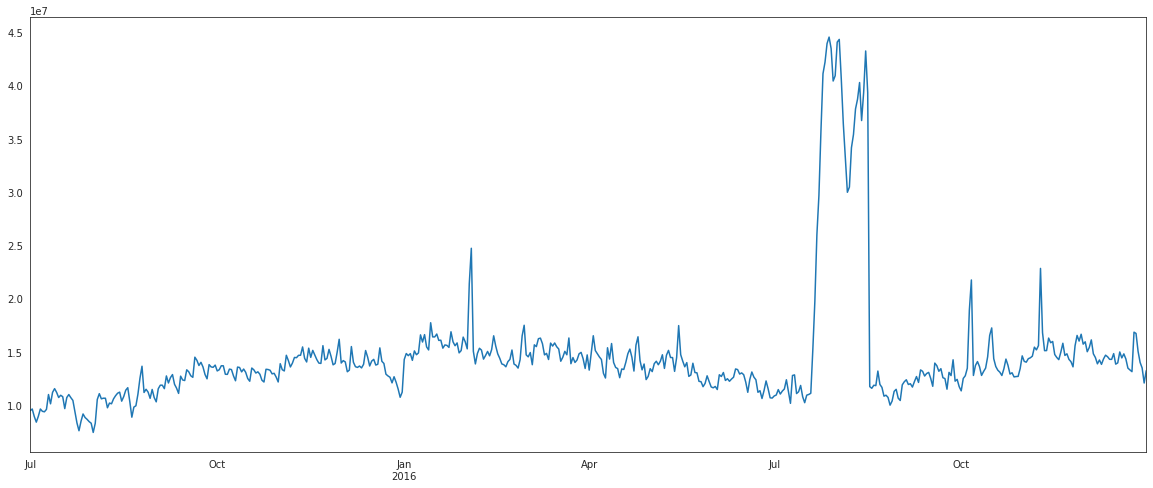

In [ ]:
ts.ru.plot()

## 7.5 Spanish page Time Series

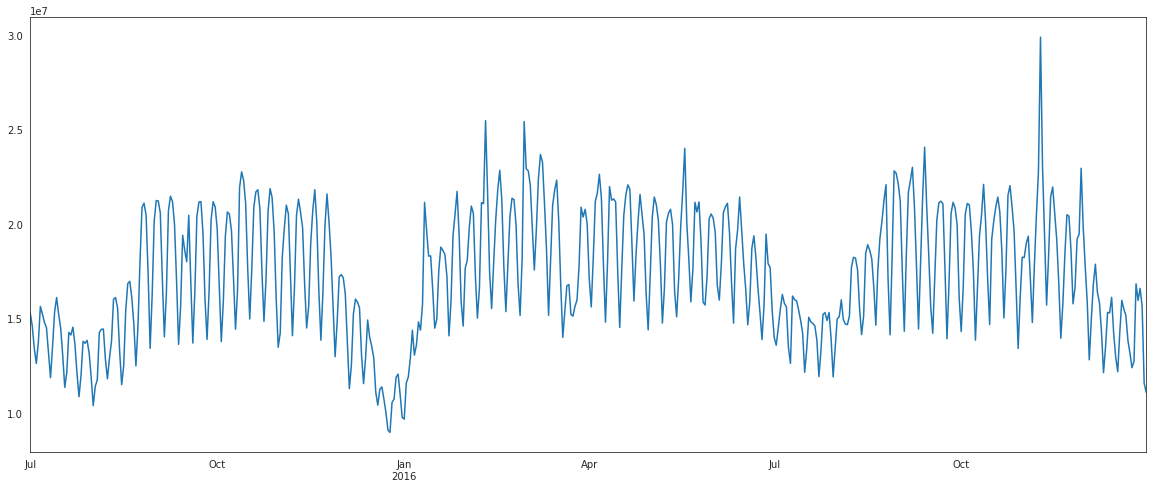

In [ ]:
ts.es.plot()

## 7.6 French page Time Series

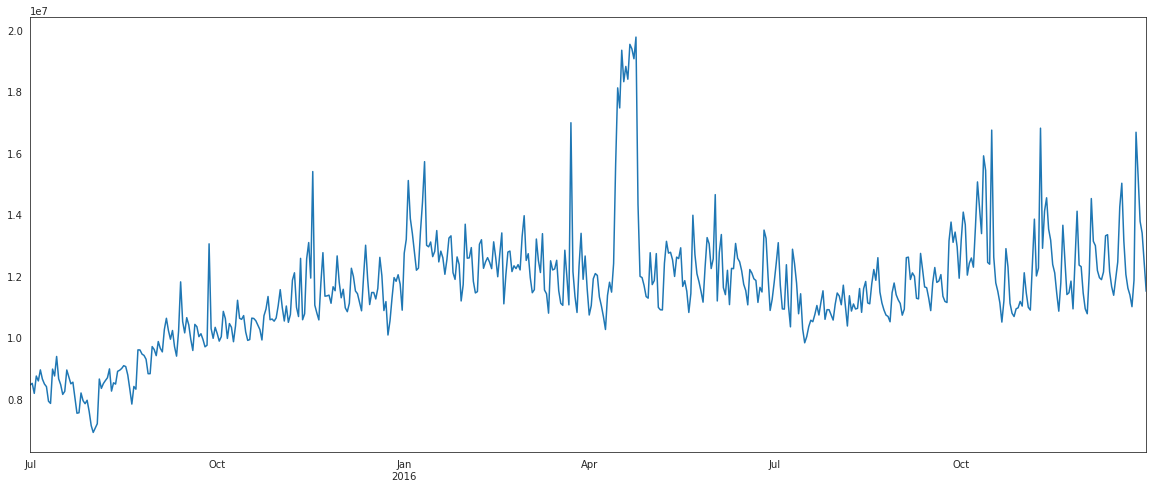

In [ ]:
ts.fr.plot()

## 7.7 German page Time Series

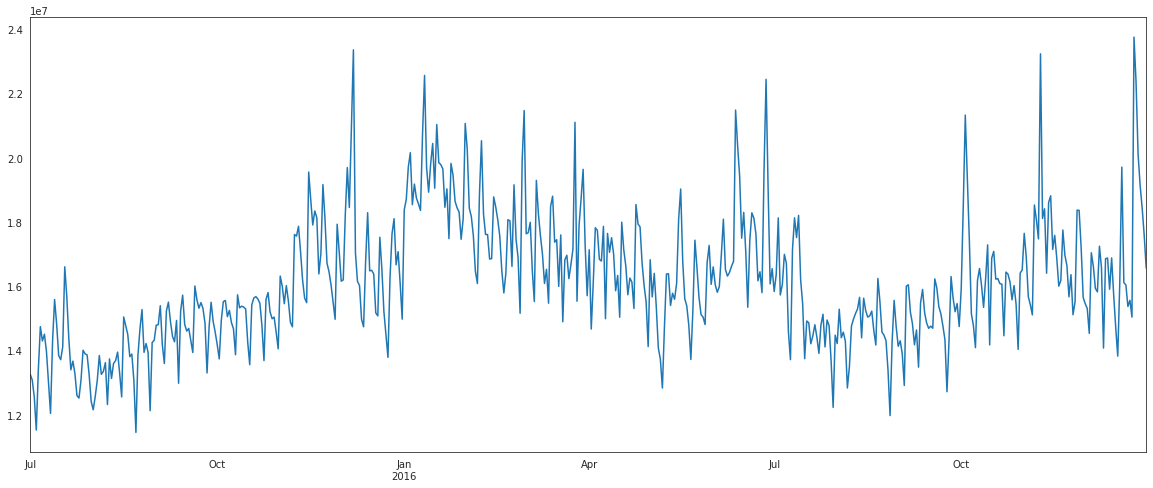

In [ ]:
ts.de.plot()

## 7.8 Language wise Page views

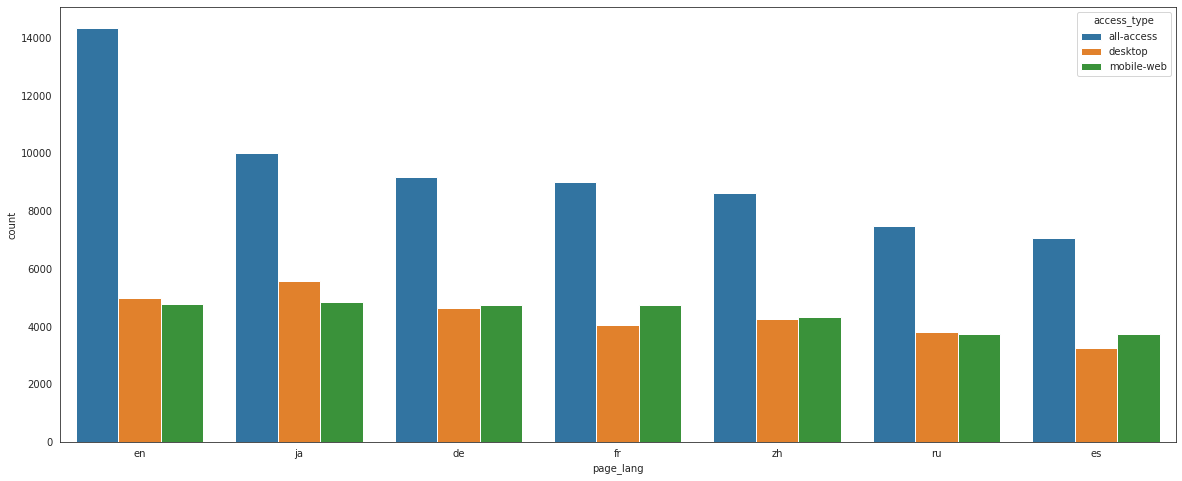

In [ ]:
sns.countplot(data=df, x="page_lang", hue="access_type",order = df['page_lang'].value_counts().index)

- **Observation**
  - English pages has most views followed by japanese , German and french pages 
  - Desktop pages are mostly viewed in japan 

# 8. Checking stationarity

- Checking stationarity
    - Formatting the data for the model
    - Dickey fuller test
    - Decomposition
    - Differencing

## 8.1 Formatting the data for the model

- Sorting data in order of index
- Perform linear interpolation
- Taking care of anomalies by clipping values using quantiles
- Plotting the english time series

In [ ]:
# Sorting data in order of index
ts.sort_index(inplace=True)

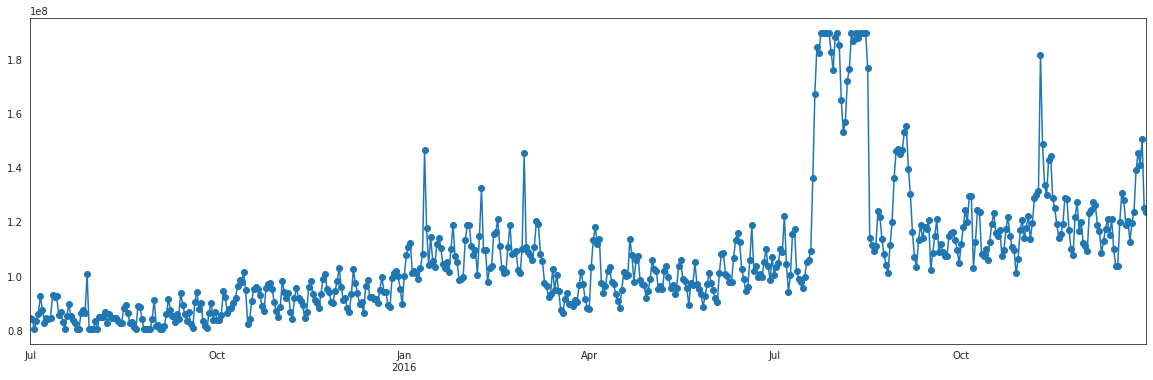

In [ ]:
# index already set as date column

# linear interpolation 
ts.en = ts.en.interpolate(method='linear')

# anomalies - clip quantiles
ts.en = ts.en.clip(upper=ts.en.quantile(0.98), lower=ts.en.quantile(0.02))

# plot
ts.en.plot(style='-o', figsize=(20,6))

## 8.2 Dickey fuller test

In [ ]:
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

In [ ]:
adf_test(ts.en)

Sequence is not stationary


## 8.3 Decomposition

### 8.3.1 Decomposition - Generic function page laugauge

In [ ]:
def seasonal_decompose_by_page_language(page_language):      
    print("************** (START) seasonal_decompose by language - "+page_map[page_language]+" **************")
    decomposition = sm.tsa.seasonal_decompose(ts[page_language], model='multiplicative',period = 3)
    display(decomposition.plot())
    display(adf_test(decomposition.resid.dropna()))
    print("************** (END) seasonal_decompose by language - "+page_map[page_language]+" **************")

### 8.3.2 Decomposition - Generic function for all languages

In [ ]:
def generic_seasonal_decompose_all_page_language(data):
    for lang in data.columns:
      seasonal_decompose_by_page_language(lang)

************** (START) seasonal_decompose by language - German **************


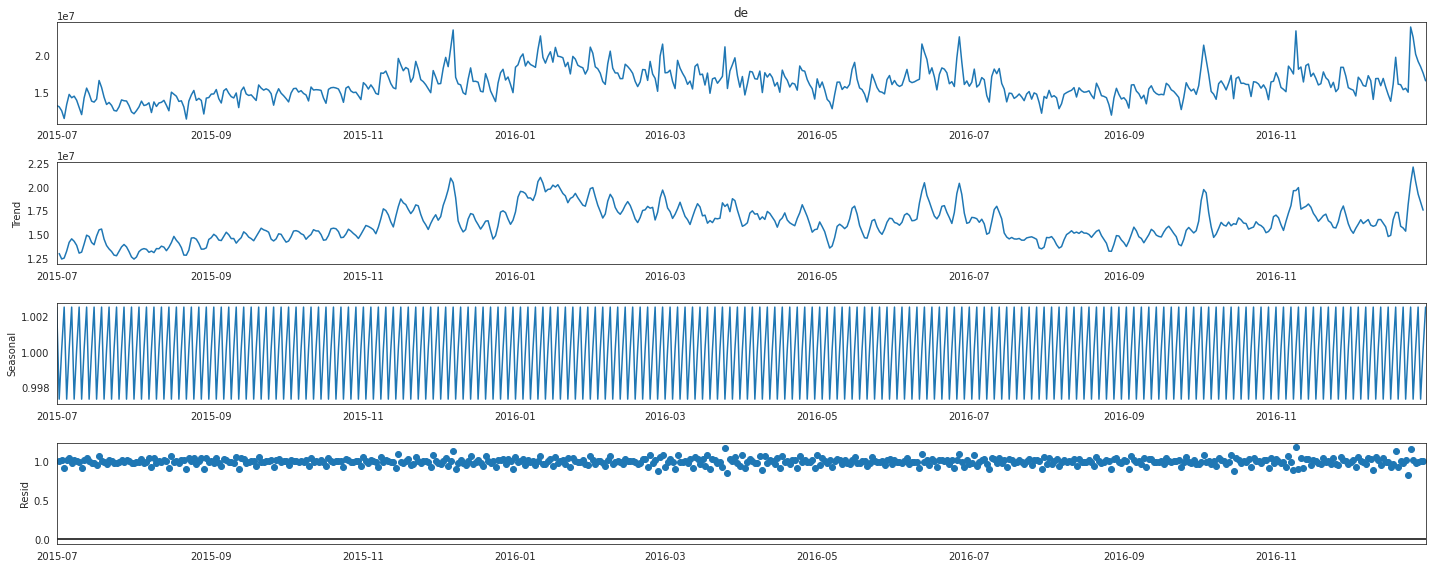

Sequence is stationary


None

************** (END) seasonal_decompose by language - German **************
************** (START) seasonal_decompose by language - English **************


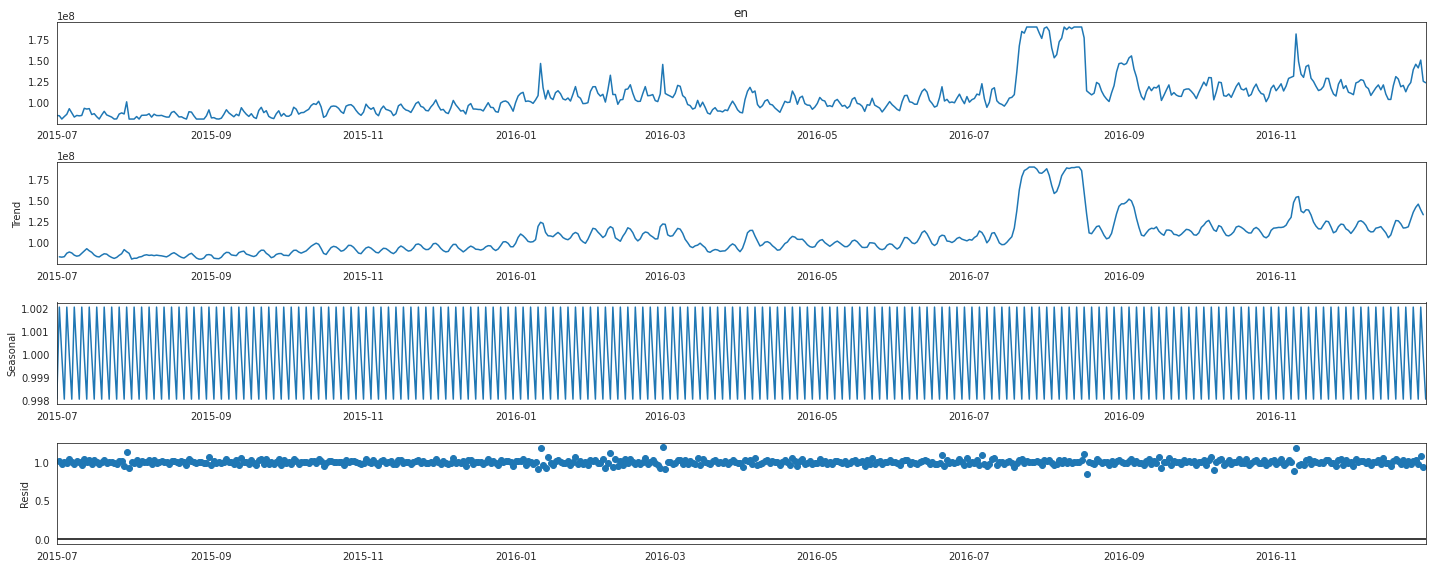

Sequence is stationary


None

************** (END) seasonal_decompose by language - English **************
************** (START) seasonal_decompose by language - Spanish **************


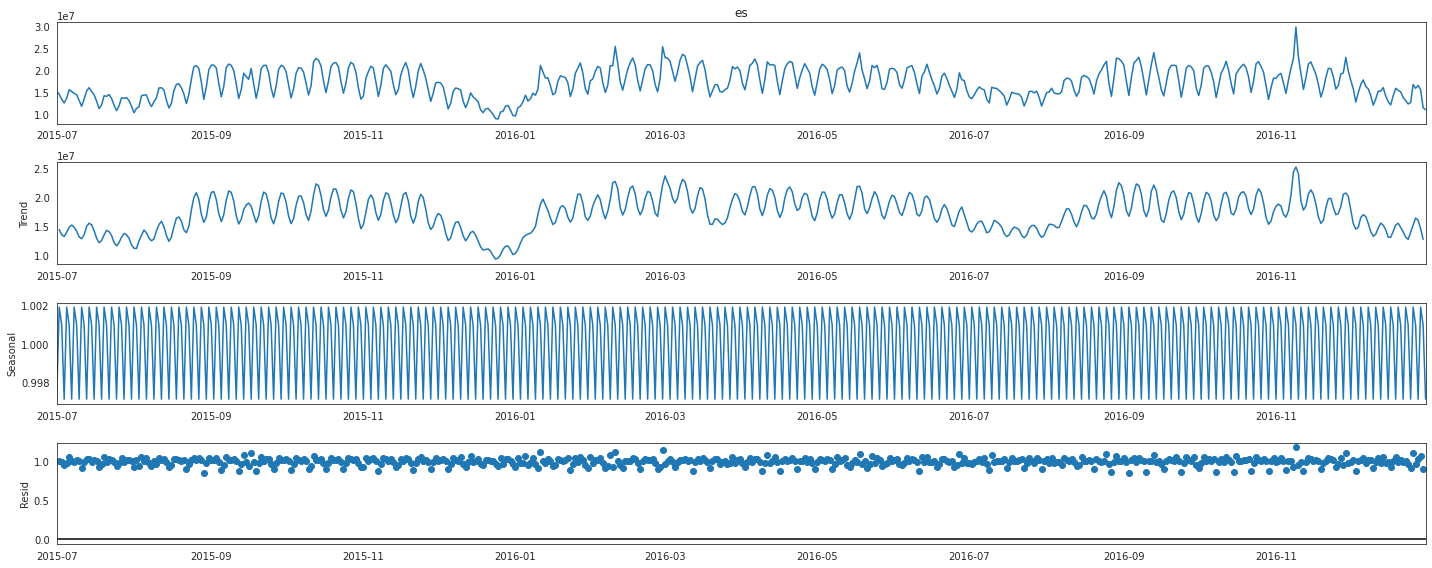

Sequence is stationary


None

************** (END) seasonal_decompose by language - Spanish **************
************** (START) seasonal_decompose by language - French **************


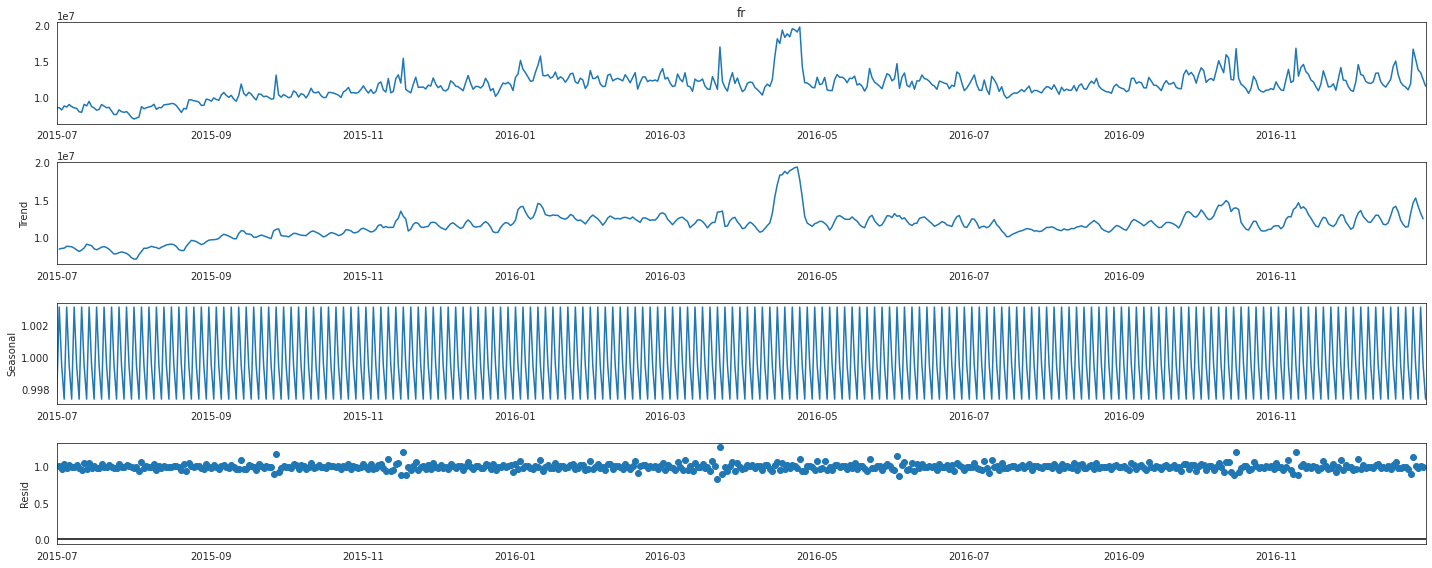

Sequence is stationary


None

************** (END) seasonal_decompose by language - French **************
************** (START) seasonal_decompose by language - Japanese **************


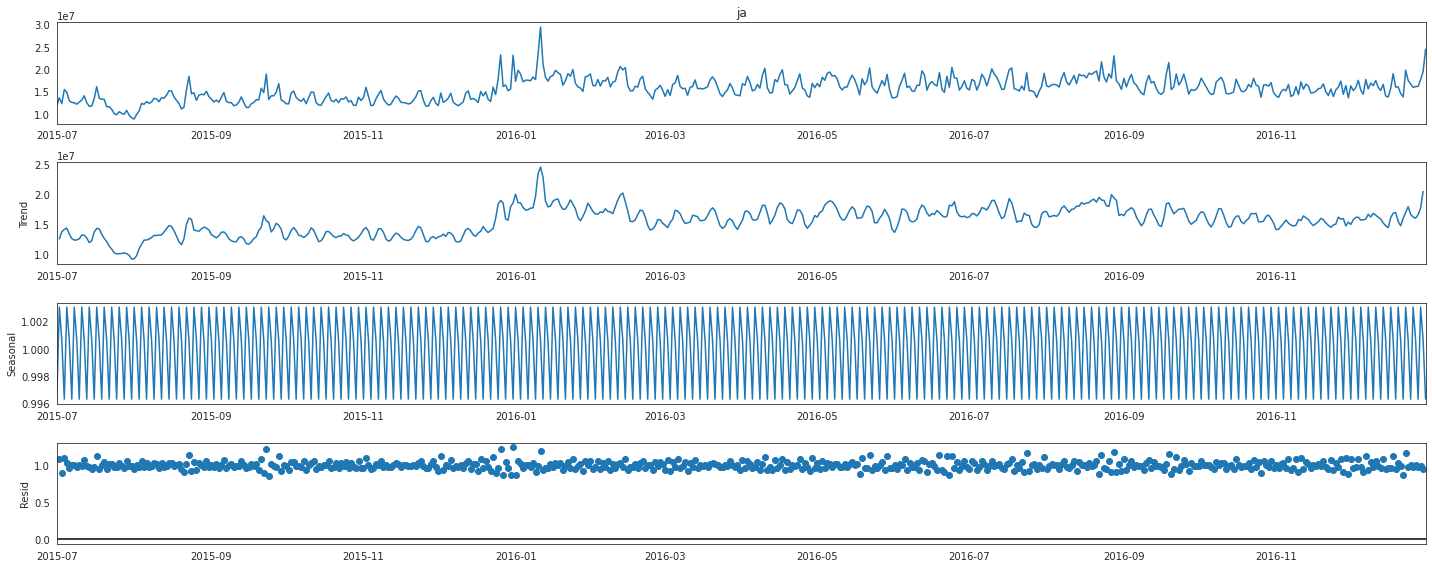

Sequence is stationary


None

************** (END) seasonal_decompose by language - Japanese **************
************** (START) seasonal_decompose by language - Russian **************


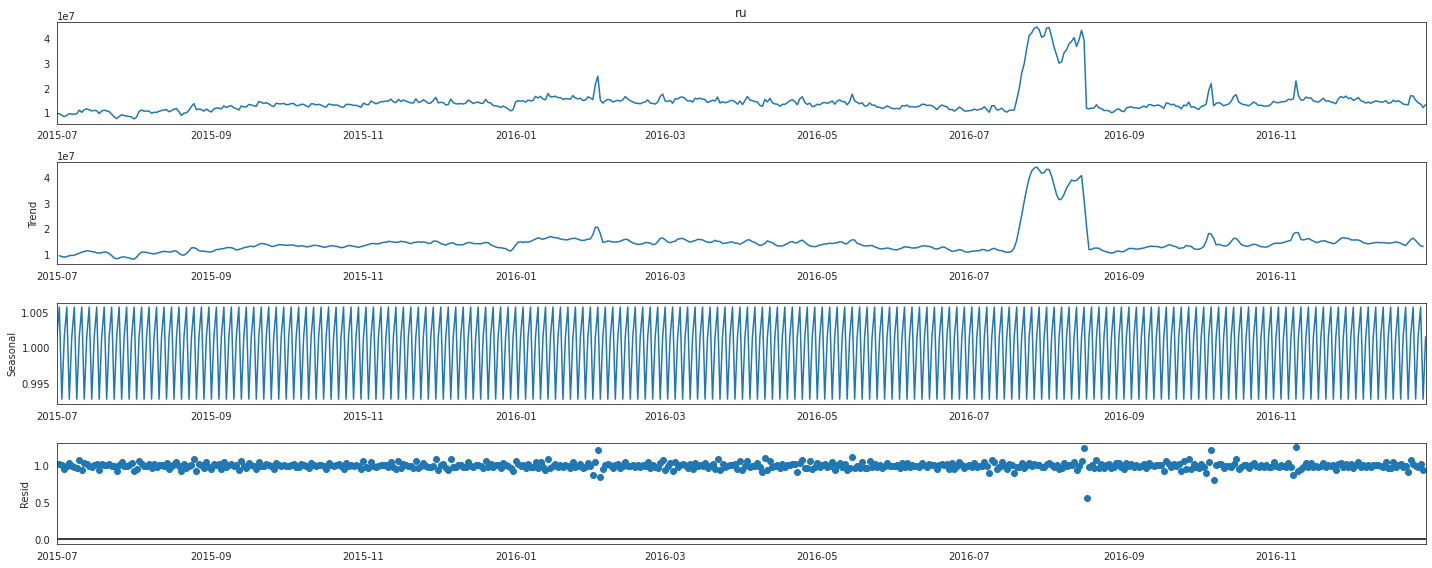

Sequence is stationary


None

************** (END) seasonal_decompose by language - Russian **************
************** (START) seasonal_decompose by language - Chinese **************


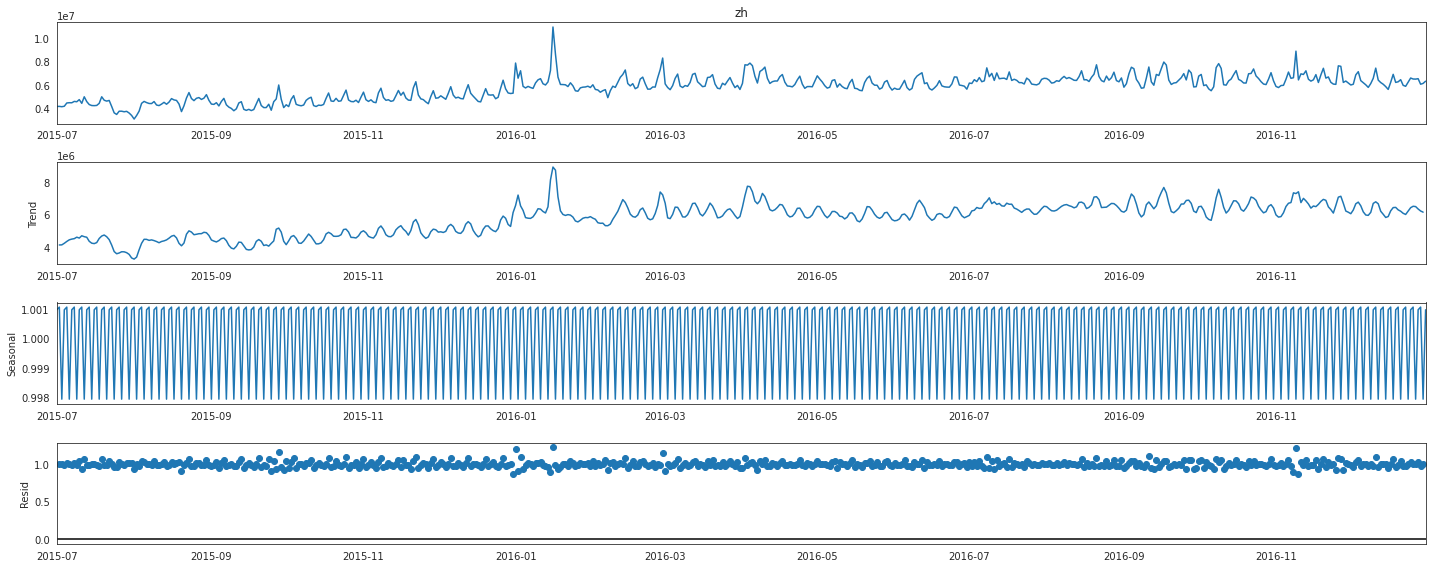

Sequence is stationary


None

************** (END) seasonal_decompose by language - Chinese **************


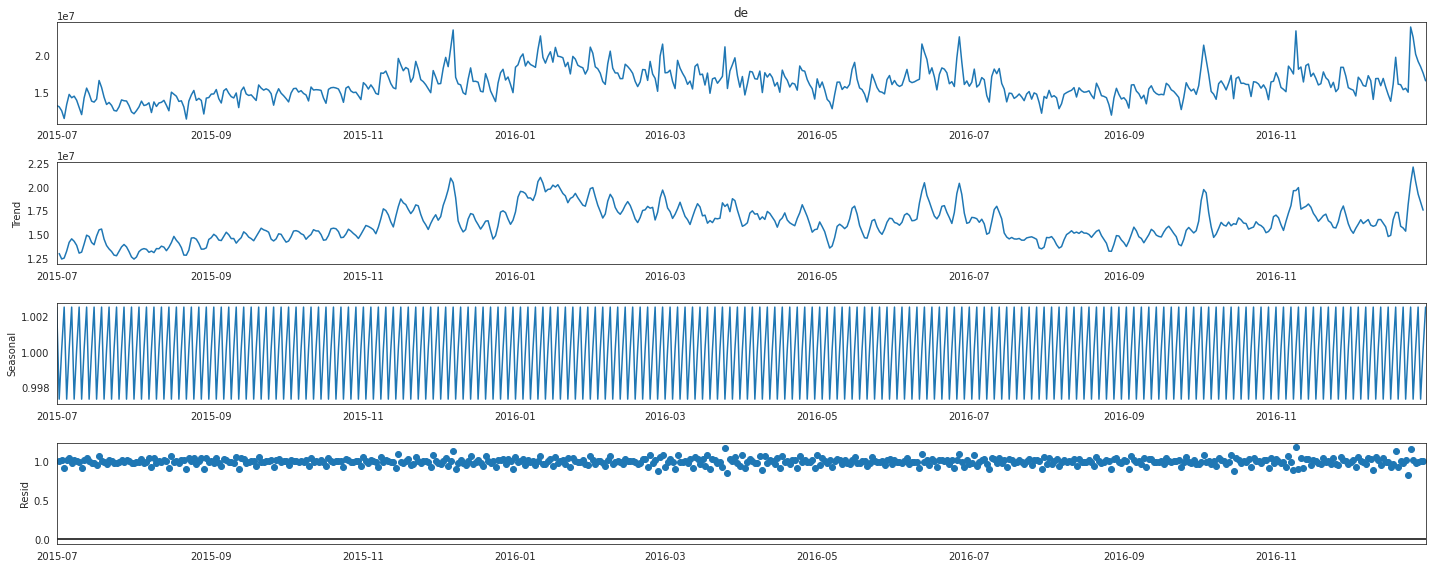

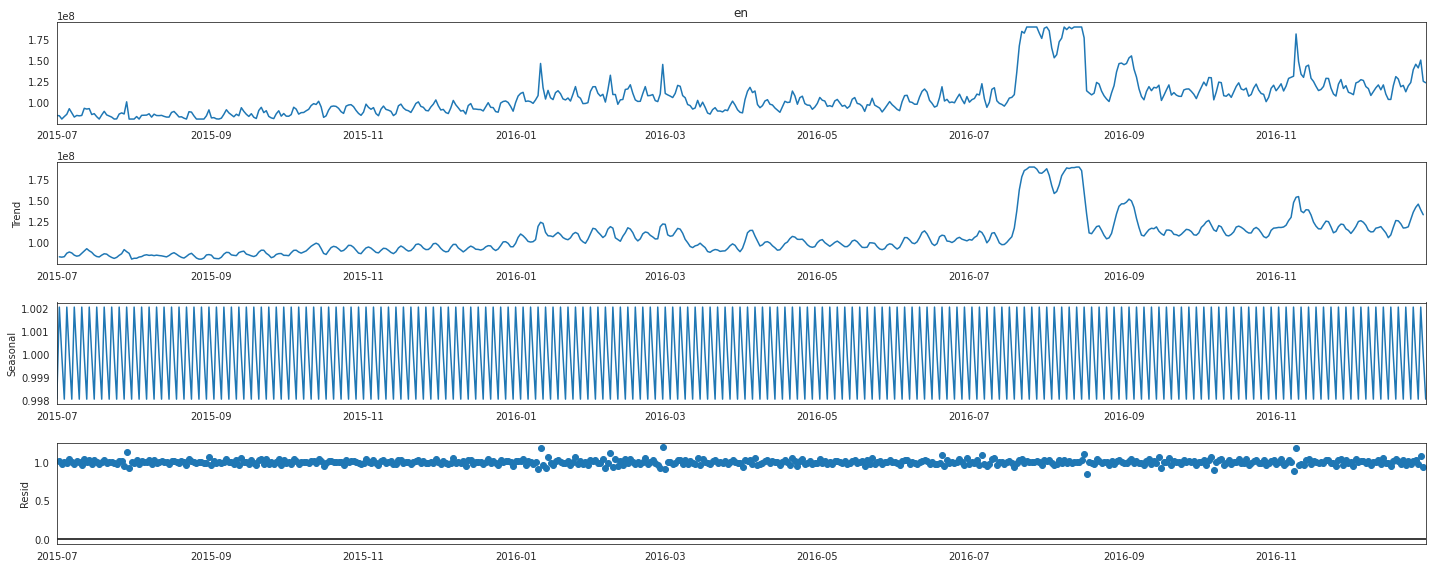

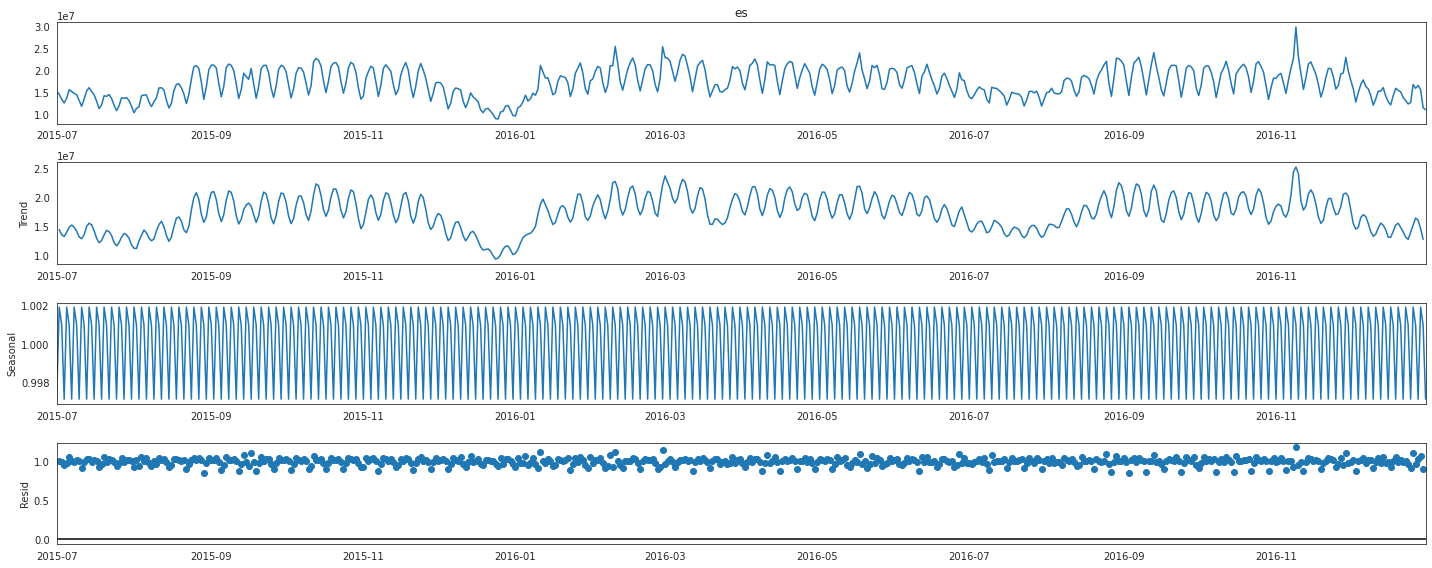

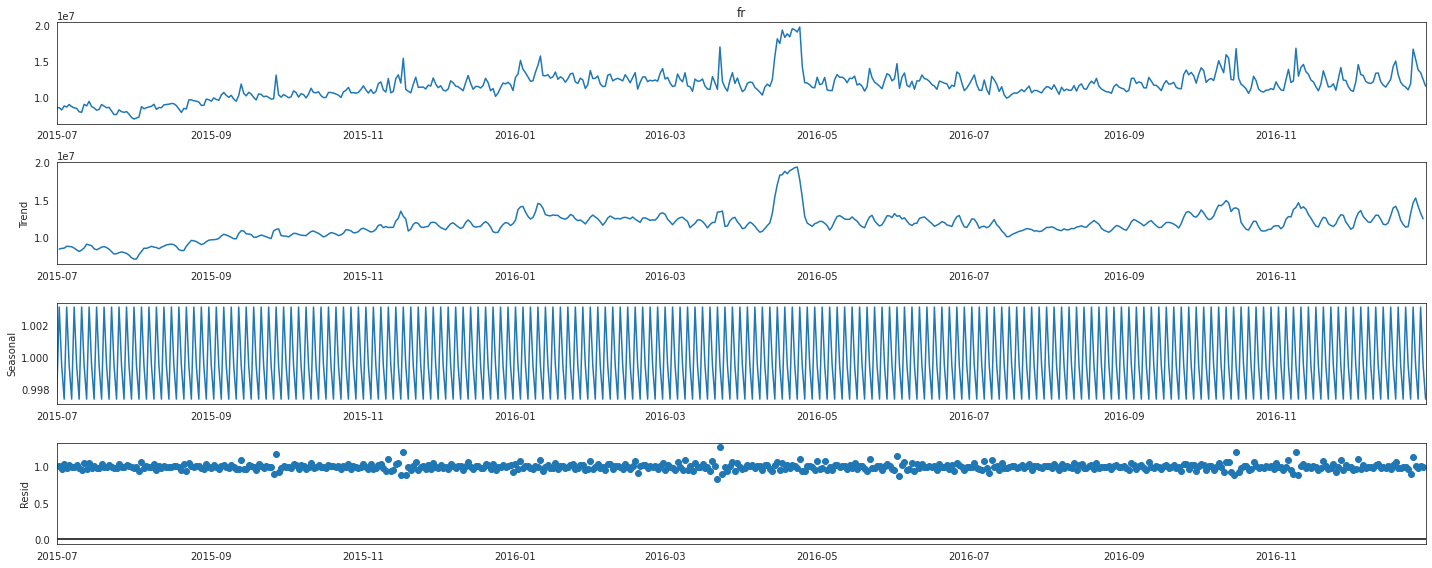

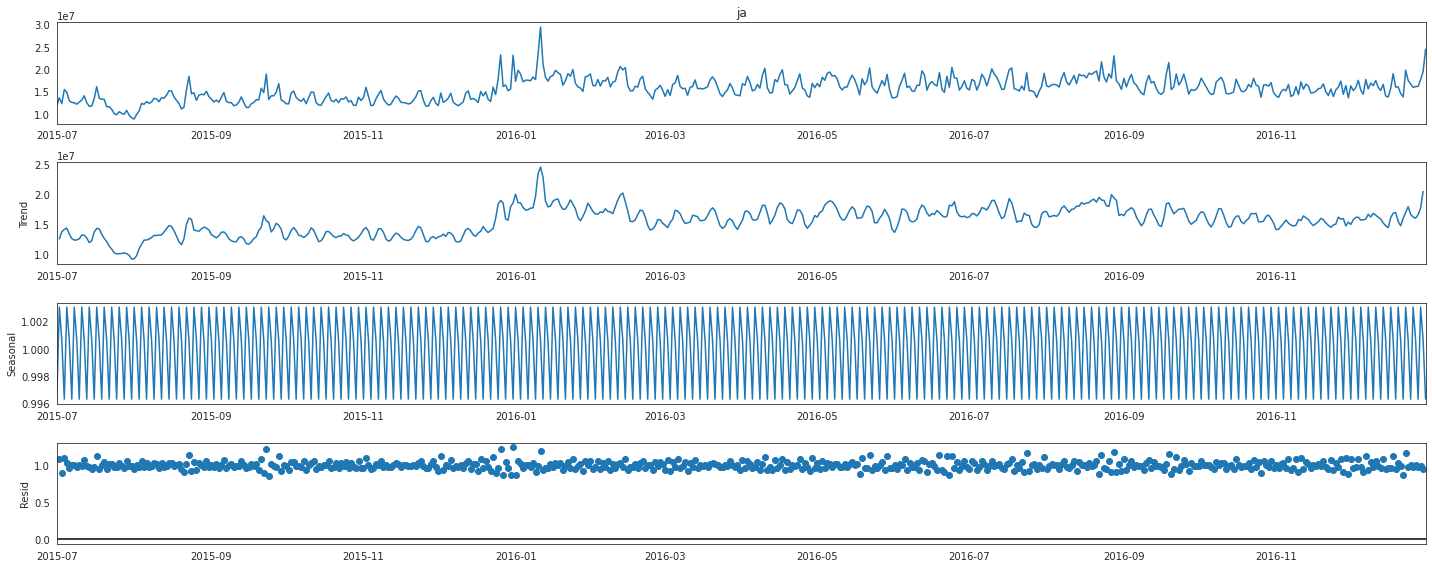

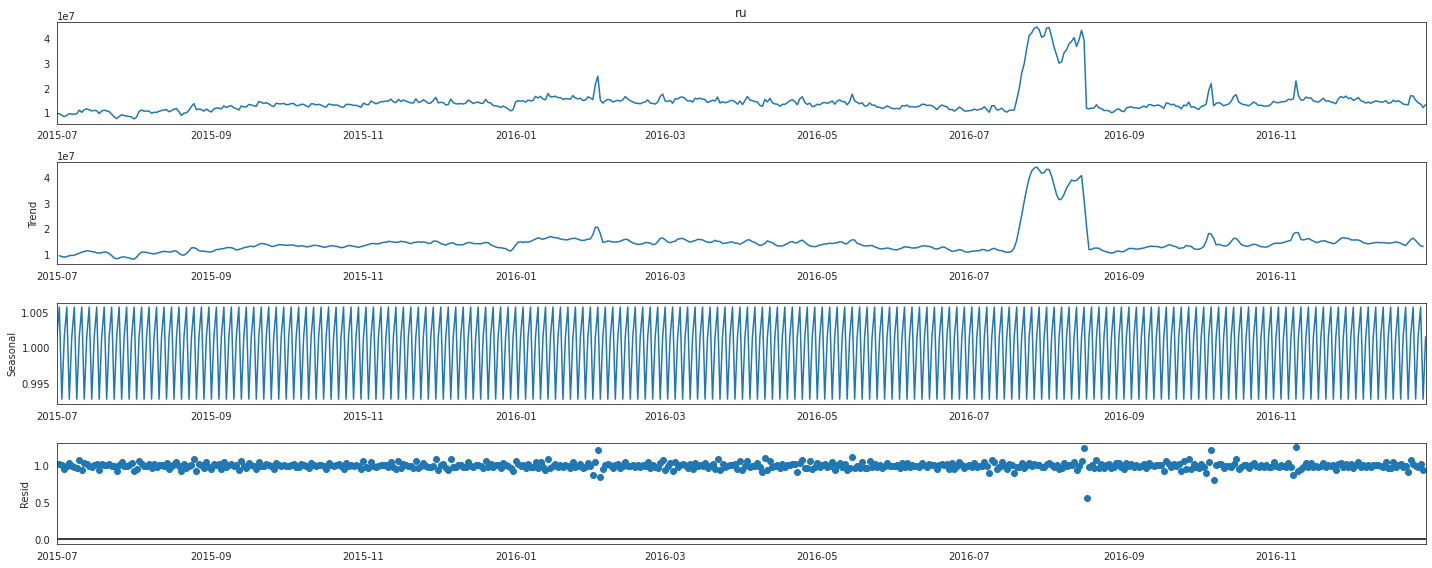

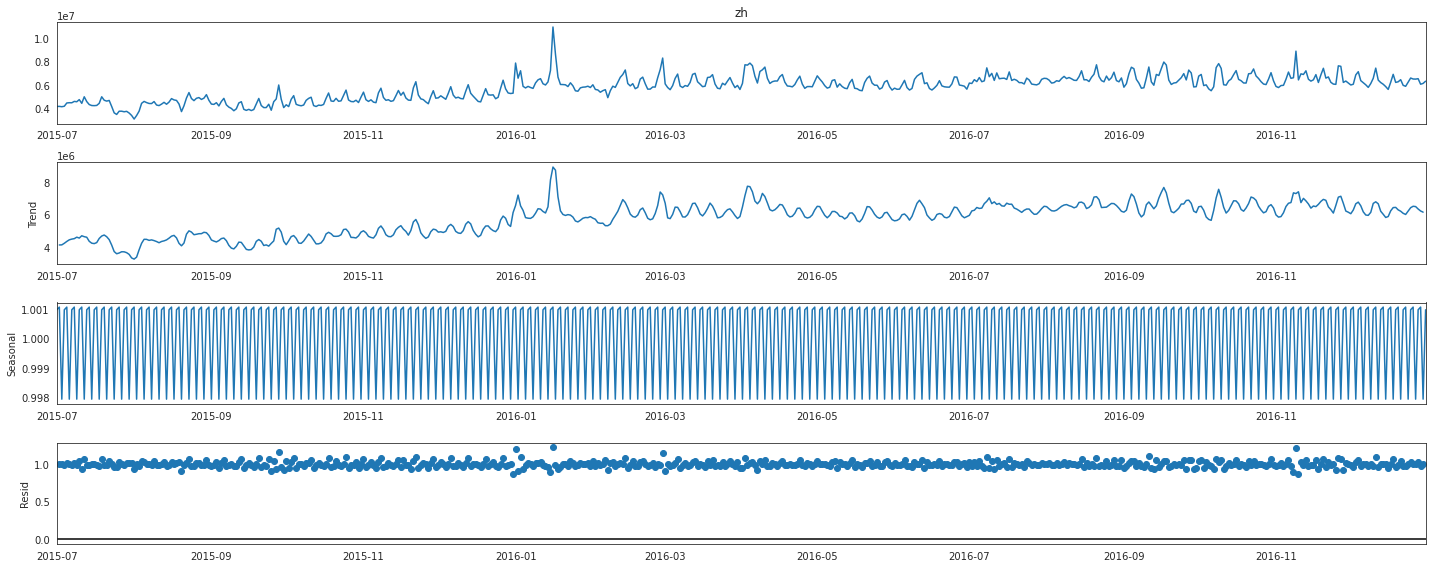

In [ ]:
generic_seasonal_decompose_all_page_language(ts)

## 8.4 Differencing

- **Observation**
  - Sequences for all language timeseries are sationary 
  - **No need for further differencing** 

# 9. Creating model training and forecasting with ARIMA, SARIMAX

- Creating model training and forecasting with ARIMA, SARIMAX (20 points)
    - ACF and PACF plot.
    - Training the model.
    - Forecasting for different languages/regions.
    - Plotting the final results

## 9.1 ACF and PACF plot

### 9.1.1 Generic Function - ACF and PACF plot

In [ ]:
def acf_pacf_plot_by_page_language(page_language):      
    print("************** (START) plotting - ACF for time series "+page_map[page_language]+" **************")
    display(plot_acf(ts[page_language], lags=36))
    print("************** (START) plotting - ACF for time series "+page_map[page_language]+" **************")

    print("************** (START) plotting - PACF for time series "+page_map[page_language]+" **************")
    display(plot_pacf(ts[page_language], lags=36))
    print("************** (START) plotting - PACF for time series "+page_map[page_language]+" **************")

************** (START) plotting - ACF for time series English **************


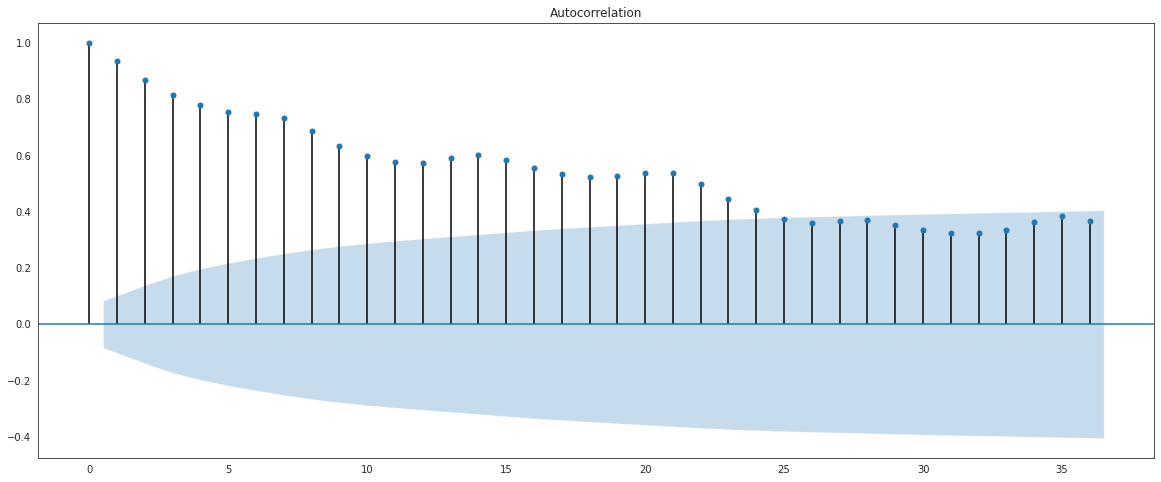

************** (START) plotting - ACF for time series English **************
************** (START) plotting - PACF for time series English **************


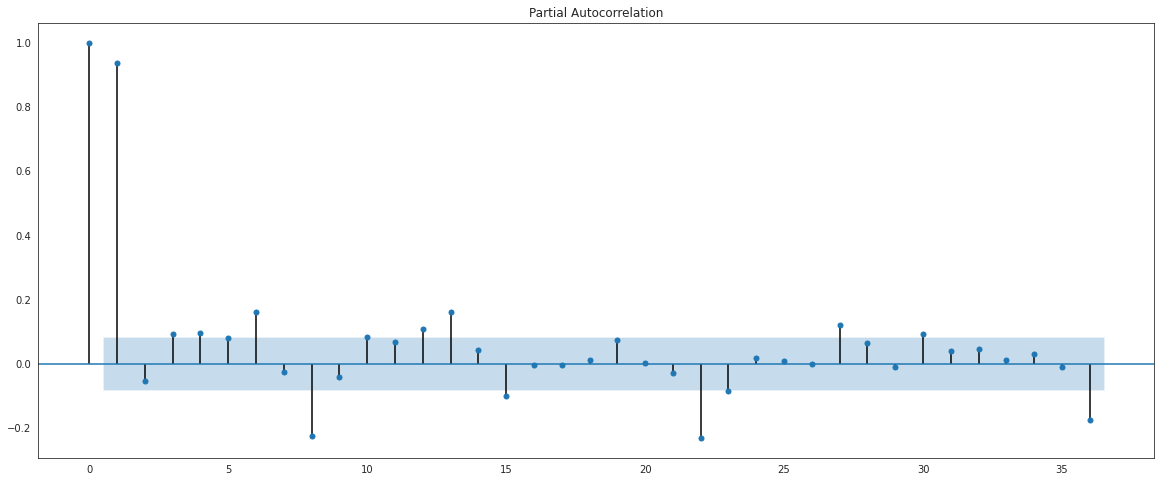

************** (START) plotting - PACF for time series English **************


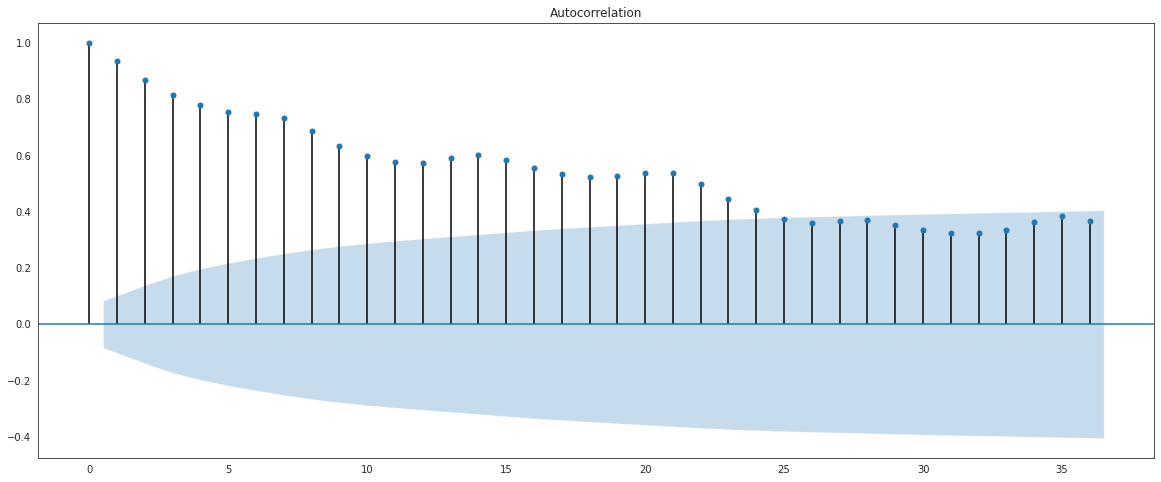

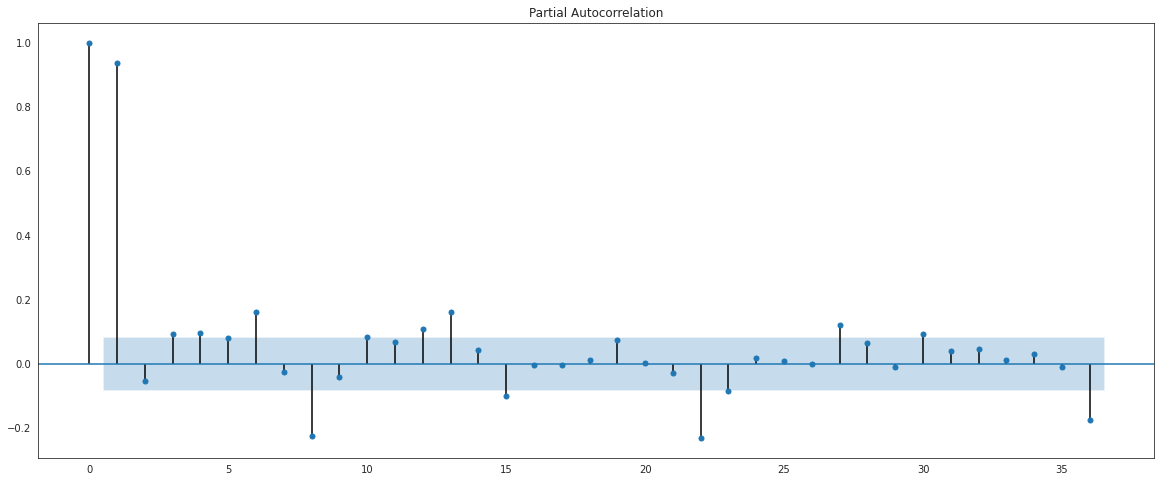

In [ ]:
acf_pacf_plot_by_page_language("en")

## 9.2 Training the model

### 9.2.1 Performance Metrics Function

#### 9.2.1.1. Mean Square Error (MSE)
- Takes the average of the square of the difference between the original values and the predicted values.
- As we take square of the error, the effect of **larger errors** (sometimes outliers) become **more pronounced** then smaller error as a result of which model will be **penalized more for bad predictions**.
- Before applying MSE, we must **eliminate all nulls/infinites** from the input.
- **Not robust** to outliers
- **Range (0, + infinity]**

#### 9.2.1.2. Root Mean Square Error (RMSE)
- Root mean Squared Error is defined as the square root of the average of the squared difference between the predicted values and actual values.
It is essentially the square root of MSE
- Notice that the RMSE is **greater than MAE**. 
- The reason is RMSE is squaring the difference between the predictions and the ground truth, any significant difference is made more substantial when it is being squared. 
- **RMSE is more sensitive to outliers.**

#### 9.2.1.3. **Mean Absolute Percentage Error** (MAPE)
It is obtained by dividing the absolute error with actual value and finding the mean of these terms.
- **Advantage**
  - In other metrics we've seen, we would need to look at that metric's value for all the models we're trying, to understand how each model performs. 
They provide relative comparison of models.
  - With MAPE, we get an percentage of correct forecasts. We don't need to to look at MAPE values of other models to get an idea of how our model is performing.

In [ ]:
# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

### 9.2.2 Train Test Split

- For time series data, we do not perform a random shuffle for train and test data split.
- Random shuffling on time series data would be meaningless since it is a collection of data over time and we look at the past data to predict future values.
- Therefore, we do a time-based splitting. 
- In the train-test split we hold out the most recent data to be as the test data.
- If there is seasonality present in the data atleast two full seasons of data are to be taken as the test data.
- For example, for our problem dataset, out of the 18 months of data (between 2015-07-01 and 2016-12-31), we decide to train on 17 months of data and use the last month, i.e. the last 1 value for test data.

In [ ]:
train_x = ts.loc[ts.index < ts.index[-31]].copy()
test_x = ts.loc[ts.index >= ts.index[-31]].copy()
test_x

page_lang           de           en          es          fr          ja  \
2016-12-01 15455209.00 111159461.00 17732257.00 10938734.00 16269616.00   
2016-12-02 15306968.00 109467638.00 15843334.00 10775120.00 15230542.00   
2016-12-03 14533278.00 123415683.00 12803118.00 12106127.00 15869416.00   
2016-12-04 17043361.00 124686441.00 14930947.00 14521806.00 17508258.00   
2016-12-05 16618905.00 127318828.00 16797594.00 13132848.00 15324619.00   
2016-12-06 15934483.00 126321634.00 17857859.00 12990208.00 14395782.00   
2016-12-07 15824540.00 119067425.00 16367965.00 12181917.00 17700847.00   
2016-12-08 17246991.00 116664698.00 15831139.00 11948821.00 15594238.00   
2016-12-09 16578087.00 108556739.00 14289069.00 11884137.00 16879847.00   
2016-12-10 14073742.00 113151538.00 12122513.00 12134770.00 16318726.00   
2016-12-11 16857126.00 117612405.00 13477042.00 13311904.00 17467842.00   
2016-12-12 16878201.00 121038274.00 15308953.00 13346529.00 15945173.00   
2016-12-13 15905752.00 115256926.00 15283991.00 12149107.00 15249476.00   
2016-12-14 16880203.00 121088799.00 16106095.00 11657527.00 16604488.00   
2016-12-15 15728435.00 110158419.00 14207497.00 11376640.00 13997880.00   
2016-12-16 14717671.00 103840201.00 12935726.00 11907029.00 13785515.00   
2016-12-17 13823599.00 103803798.00 12170153.00 12458313.00 15685681.00   
2016-12-18 16113213.00 120028790.00 14250741.00 14251024.00 19007555.00   
2016-12-19 19711490.00 130939883.00 15947831.00 15020200.00 15992235.00   
2016-12-20 16112933.00 128043832.00 15486635.00 13141812.00 16058189.00   
2016-12-21 16041249.00 118888048.00 15143760.00 12056098.00 14546585.00   
2016-12-22 15370604.00 120491573.00 13837820.00 11606988.00 13793066.00   
2016-12-23 15561414.00 112905341.00 13155676.00 11383657.00 19777366.00   
2016-12-24 15037095.00 119860920.00 12385052.00 11005480.00 17501297.00   
2016-12-25 23760349.00 123926291.00 12713363.00 11867509.00 16720214.00   
2016-12-26 22376548.00 139112120.00 16819231.00 16678423.00 15918093.00   
2016-12-27 20125264.00 145628731.00 15945353.00 15281470.00 16123301.00   
2016-12-28 19152389.00 141278366.00 16577375.00 13781521.00 16150715.00   
2016-12-29 18447906.00 150557534.00 15647135.00 13399796.00 17682688.00   
2016-12-30 17606030.00 125404585.00 11560095.00 12471074.00 19450687.00   
2016-12-31 16562720.00 123623809.00 11077924.00 11504691.00 24460799.00   

page_lang           ru         zh  
2016-12-01 15932902.00 5976786.00  
2016-12-02 15003719.00 6040025.00  
2016-12-03 15404851.00 6838108.00  
2016-12-04 16113071.00 7110847.00  
2016-12-05 14810896.00 6347824.00  
2016-12-06 14458992.00 6164263.00  
2016-12-07 13866905.00 5992784.00  
2016-12-08 14227271.00 5771392.00  
2016-12-09 13816375.00 6098234.00  
2016-12-10 14326020.00 6546507.00  
2016-12-11 14678903.00 7414653.00  
2016-12-12 14532205.00 6393446.00  
2016-12-13 14289724.00 6183974.00  
2016-12-14 14286190.00 6039418.00  
2016-12-15 14825301.00 5839569.00  
2016-12-16 13837431.00 5597992.00  
2016-12-17 13955354.00 6209873.00  
2016-12-18 14980170.00 6884550.00  
2016-12-19 14421621.00 6196031.00  
2016-12-20 14800611.00 6249466.00  
2016-12-21 14321477.00 6428076.00  
2016-12-22 13465000.00 5946850.00  
2016-12-23 13292086.00 5865102.00  
2016-12-24 13133353.00 6215165.00  
2016-12-25 16839517.00 6569812.00  
2016-12-26 16717095.00 6485813.00  
2016-12-27 15040168.00 6478442.00  
2016-12-28 14000319.00 6513400.00  
2016-12-29 13478977.00 6042545.00  
2016-12-30 12066750.00 6111203.00  
2016-12-31 13223033.00 6298565.00

### 9.2.3 ARIMA - Generic Function

In [ ]:
def arima_by_page_language(page_language):
  # Building Model
  model = SARIMAX(train_x[page_language], order=(3, 1, 3)) 
  model = model.fit(disp=False)
  # Forecasting Model
  test_x['pred'] = model.forecast(steps=12)
  # Actual vs Forecast
  display(test_x[page_language].fillna(0).plot(style='-o'))
  test_x['pred'].fillna(0).plot(style='-o')
  # Display performance 
  display(performance(test_x[page_language].fillna(0), test_x['pred'].fillna(0)))

MAE : 78046824.94
RMSE : 97625844.785
MAPE: 0.63


None

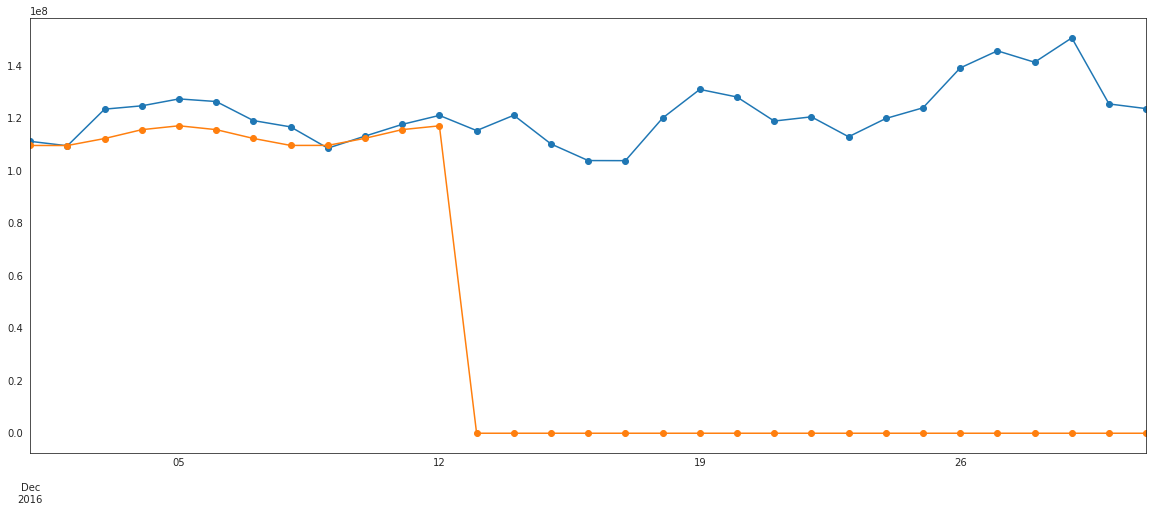

In [ ]:
arima_by_page_language("en")

### 9.2.4 SARIMAX

In [ ]:
def sarima_by_page_language(page_language):
  # Building Model
  model = SARIMAX(train_x.en, order=(5, 1, 3), seasonal_order=(1,1,1,12))  
  model = model.fit(disp=False)
  # Forecasting Model
  test_x['pred'] = model.forecast(steps=12)

  # Actual vs Forecast
  display(test_x[page_language].fillna(0).plot(style='-o'))
  test_x['pred'].fillna(0).plot(style='-o')

  # Display Performance
  display(performance(test_x[page_language].fillna(0), test_x['pred'].fillna(0)))

MAE : 78153692.391
RMSE : 97623877.55
MAPE: 0.631


None

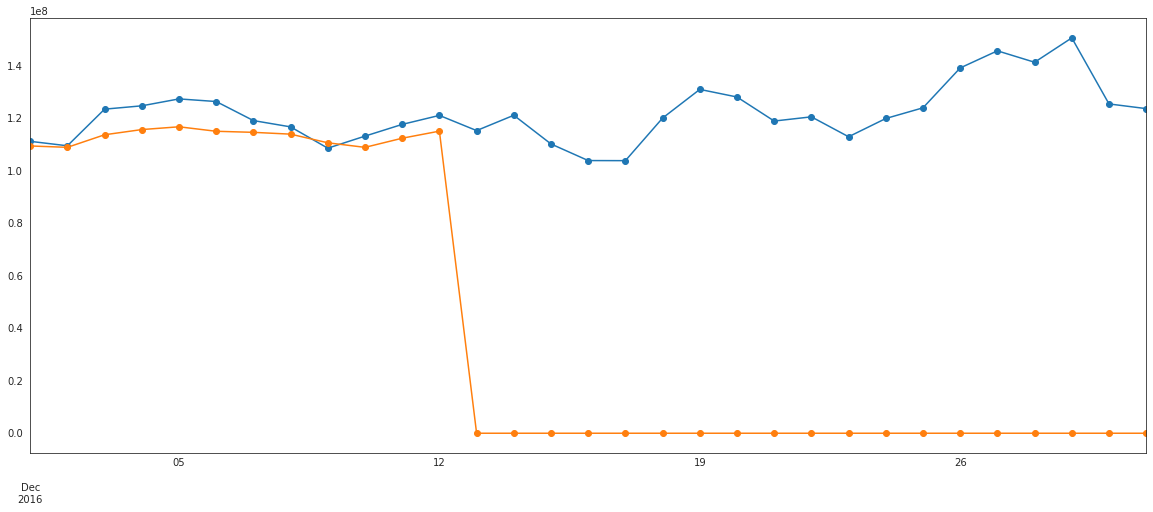

In [ ]:
sarima_by_page_language("en")

## 9.3 Forecasting for different languages

MAE : 45035177.577
RMSE : 66456973.956
MAPE: 7.098


None

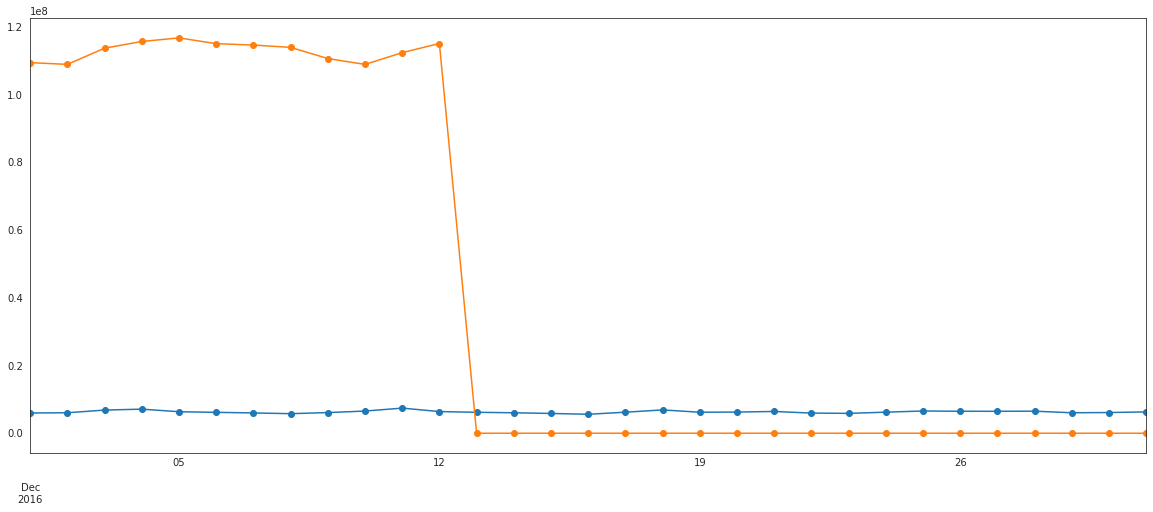

In [ ]:
sarima_by_page_language("zh")

## 9.4 Hyperparameter Tunning - GridSearch

In [ ]:
### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, lang="en", maxiter=50):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        lang : Page language for selective time series forecasting , default is time series is for english dataset 
        maxiter : number of iterations, increase if your model isn't converging
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                model = SARIMAX(train_x[lang], # this is your time series you will input
                                order=comb,
                                seasonal_order=combs
                )
                

                output = model.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except Exception as e:
                print("Exception {} ".format(str(e)))
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [ ]:
### Apply function to your time series data ###
# Remember to change frequency to match your time series data
#sarimax_gridsearch(ts, pdq, pdqs,maxiter=100)

- **Observation**
  - Grid search not converging 

# 10. Forecasting with prophet

## 10.1 Prepare data

In [ ]:
display(exog_df.shape)
display(ts.shape)

(550, 1)

(550, 7)

In [ ]:
# Required !!
df_pf = pd.DataFrame(index=ts.index)
df_pf["ds"] = df_pf.index
exog_df.index = ts.index 
df_pf["y"] = ts["en"]
df_pf["holiday"] = exog_df["Exog"].fillna(0)

df_pf.head()

ds           y  holiday
2015-07-01 2015-07-01 84712190.00        0
2015-07-02 2015-07-02 84438545.00        0
2015-07-03 2015-07-03 80518513.72        0
2015-07-04 2015-07-04 83463204.00        0
2015-07-05 2015-07-05 86198637.00        0

## 10.2 Create Model

### 10.2.1  Model # 1 without Exogenous events 

In [ ]:
model = Prophet()
model.fit(df_pf[['ds', 'y']][:-39])
future = model.make_future_dataframe(periods=39, freq="D")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r247uxy/27m63dkb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r247uxy/nph9uso2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91174', 'data', 'file=/tmp/tmp8r247uxy/27m63dkb.json', 'init=/tmp/tmp8r247uxy/nph9uso2.json', 'output', 'file=/tmp/tmp8r247uxy/prophet_modelqhf8d3yk/prophet_model-20230212180539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 10.2.2  Model # 2 with Exogenous events 

In [ ]:
model2=Prophet(yearly_seasonality=True, weekly_seasonality=True)
model2.add_regressor('holiday') #adding exogenous data in the model
model2.fit(df_pf[:-39])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r247uxy/4uokg4vu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r247uxy/nefw4bn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18583', 'data', 'file=/tmp/tmp8r247uxy/4uokg4vu.json', 'init=/tmp/tmp8r247uxy/nefw4bn3.json', 'output', 'file=/tmp/tmp8r247uxy/prophet_model_ryg424g/prophet_model-20230212180539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## 10.3 Forecast 

In [ ]:
forecast = model.predict(future)
forecast.head()

ds       trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2015-07-01 82977388.44 63280042.65 102218702.62  82977388.44  82977388.44   
1 2015-07-02 83055693.01 59818639.69 100948018.63  83055693.01  83055693.01   
2 2015-07-03 83133997.57 58369881.12  98208184.58  83133997.57  83133997.57   
3 2015-07-04 83212302.13 58861905.67  99808697.77  83212302.13  83212302.13   
4 2015-07-05 83290606.69 67241990.98 106400826.51  83290606.69  83290606.69   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0       -62014.01             -62014.01             -62014.01   -62014.01   
1     -2536053.67           -2536053.67           -2536053.67 -2536053.67   
2     -5443281.57           -5443281.57           -5443281.57 -5443281.57   
3     -3712385.06           -3712385.06           -3712385.06 -3712385.06   
4      3076689.10            3076689.10            3076689.10  3076689.10   

   weekly_lower  weekly_upper  multiplicative_terms  \
0     -62014.01     -62014.01                  0.00   
1   -2536053.67   -2536053.67                  0.00   
2   -5443281.57   -5443281.57                  0.00   
3   -3712385.06   -3712385.06                  0.00   
4    3076689.10    3076689.10                  0.00   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                        0.00                        0.00 82915374.44  
1                        0.00                        0.00 80519639.33  
2                        0.00                        0.00 77690716.00  
3                        0.00                        0.00 79499917.07  
4                        0.00                        0.00 86367295.79

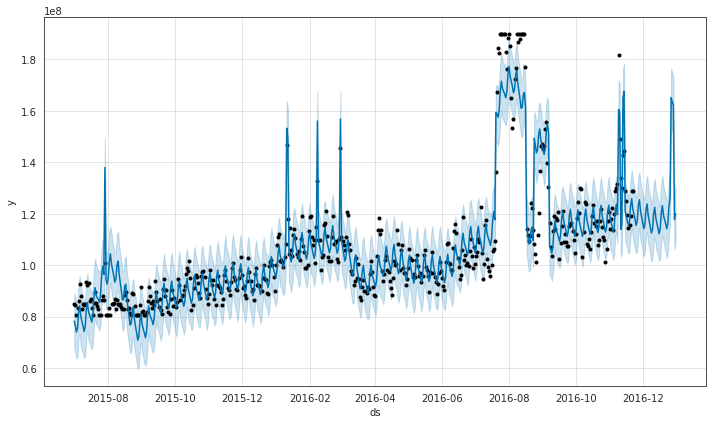

In [ ]:
forecast2 = model2.predict(df_pf)
fig = model2.plot(forecast2)

## 10.4 Performance  

In [ ]:
performance(df_pf['y'][:-39],forecast['yhat'][:-39])

MAE : 10577651.378
RMSE : 16232988.895
MAPE: 0.089


In [ ]:
performance(df_pf['y'][:-39],forecast2['yhat'][:-39])

MAE : 5830930.554
RMSE : 8696340.196
MAPE: 0.053


## 10.5 Forecasted plot  

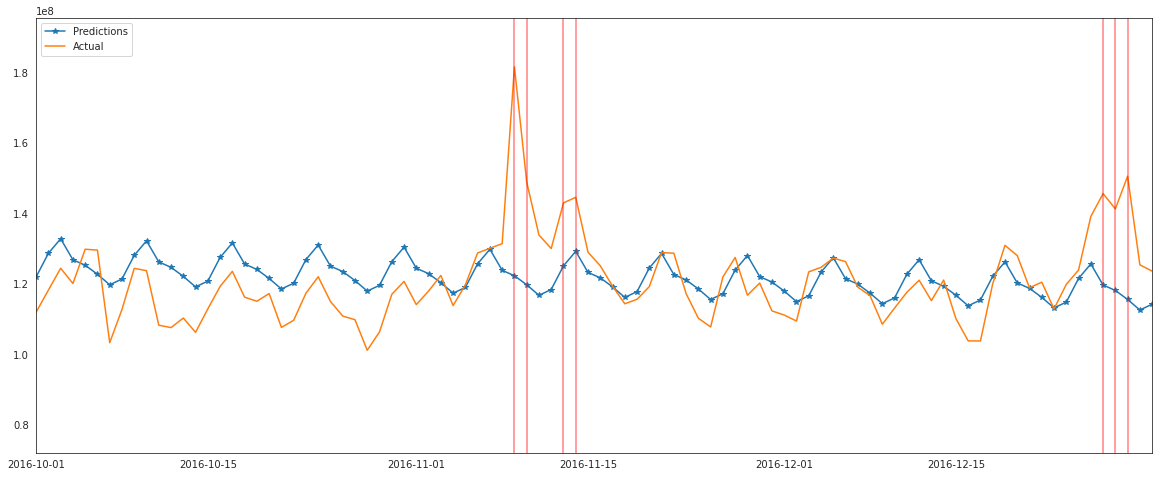

In [ ]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df_pf['ds'], df_pf['y'], label = 'Actual')
for x in df_pf.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2016-10-01'), pd.to_datetime('2016-12-31'))
plt.legend()

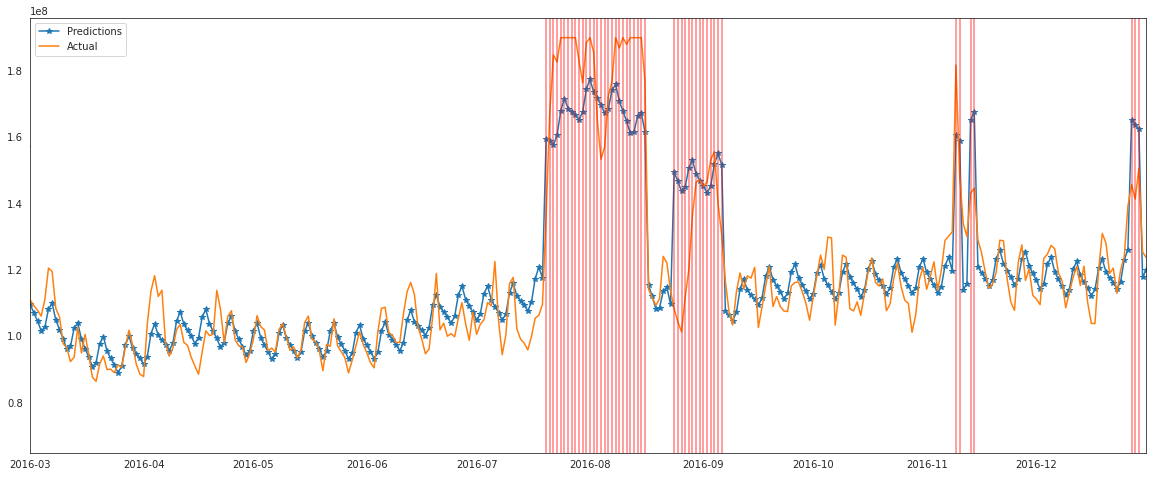

In [ ]:
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(df_pf['ds'], df_pf['y'], label = 'Actual')
for x in df_pf.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2016-03-01'), pd.to_datetime('2016-12-31'))
plt.legend()

# 11. Creating a pipeline for working with multiple series

- Creating a pipeline for working with multiple series

In [ ]:
from pandas.core.strings.accessor import NoNewAttributesMixin
class CustomProphetPageviewForecastingPipeline():
    
    def __init__(self,time_series,exogenous_events,page_language,frequency="D",is_exogenous=False):
        '''
        Initializes a Pipeline object. 
        INPUT: 
            time_series (DataFrame): Input Time series data based on which forecasting would happen 
            exogenous_events (DataFrame): Input Exogenous Event data based on which forecasting would happen
            page_language (str): Feature names which signifies page language categories such as en,zh,es
									"en":"English",
									"ja":"Japanese",
									"de":"German",
									"fr":"French",
									"zh":"Chinese",
									"ru":"Russian",
									"es":"Spanish",
            frequency (str): Frequency of forecasting type such as "D", "M" and "Y"
			      is_exogenous (boolean): If exegenous events are present or not 
            
            RETURNS:
               model and forecast
        '''
        self.time_series = time_series
        self.exogenous_events = exogenous_events
        self.page_language = page_language
        self.frequency = frequency
        self.is_exogenous = is_exogenous
        self.df_processed = self._preprocess_frames_as_prophet_prerequisite()
        self.model = None
        self.forecast = None
        self.period = None

    
    def _preprocess_frames_as_prophet_prerequisite(self):
        '''
          Preprocess data frames
          INPUT:
              Uses time_series , exogenous_events 
          OUTPUT:
              Returns: self.df_processed
        '''
		
        self.df_processed = pd.DataFrame(index=self.time_series.index)
        self.df_processed["ds"] = self.df_processed.index
        if is_exogenous == True:
          self.exogenous_events.index = self.time_series.index 
        self.df_processed["y"] = self.time_series[page_language]

        # Pre-processing exogenous data for prophet 
        if is_exogenous == True:
          self.df_processed["holiday"] = self.exogenous_events["Exog"].fillna(0)
        
        # Displaying pre-processed data for prophet
        display(self.df_processed.head())
        
        return self.df_processed
		 
    def forecast(self,periods):
        '''
        Function to use astropy.io.fits to load images into a big array
        Uses: self.df_processed , facebook Prophet 
        Sets: model
        Returns: (self.model,self.foreast)
        '''
		
        # Model - Initiation
        self.period = periods
        if is_exogenous == True:
          self.model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
          self.model.add_regressor('holiday') #adding exogenous data in the model
          self.model.fit(self.df_processed[:-periods])
        else:
          self.model = Prophet()
          self.model.fit(self.df_processed[['ds', 'y']][:-periods])
          
        # Prophet has a built-in helper function make_future_dataframe to create a dataframe of future dates. 
        # The make_future_dataframe function lets you specify the frequency and number of periods you would like to forecast into the future. By default, the frequency is set to days
        future = self.model.make_future_dataframe(periods=periods, freq=frequency)

        # Forecasting using the phophet model
        self.forecast = self.model.predict(future)
        display(self.forecast.head())

        # Plot forecast 
        fig = self.model.plot(forecast)
        display(fig)
        
        return (self.model,self.forecast)
		
    def get_performance_metrics(self):
		    # Evaluate Model Performance
		    display(performance(self.df_processed['y'][:-self.period],self.forecast['yhat'][:-self.period]))

# 12. Questionnaire

- Defining the problem statements and where can this and modifications of this be used?

  - **Forecasting the number of views** so that organization can predict and **optimize the ad placement** for the clients
  - **Forecusting** views **by region**
  - **Forecasting** views **by page title** 
  - **Forecasting** views **by season**
  - **Allow bidding** on popular **pages and seasons**
  - Exception/modifications of this could be during exegenous events like festive seasons / holidays , during seasonal offers

- Write 3 inferences you made from the data visualizations
  - English pages has most views followed by japanese , German and french pages
  - Desktop pages are mostly viewed in Japan
  - There is surge of views of Japnese pages during month of December -January both in year 2015 and 2016 
  - Likewise Sudden surge in view of English pages observed during August - September month 2016
  - There is nice seasionality observed for Spanish pages

- What does the decomposition of series do?
  - Time series decomposition involves thinking of a series as a combination of level, trend, seasonality and noise components. 
  - Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting

  - A time series can be split into several components, each representing one of the underlying categories of patterns.
  - There are three important components which we want to decompose our signal into.
    - Trend - general movement over time
    - Seasonality -  behaviors captured in individual seasonal periods
    - Residual - everything not captured by trend and seasonal components
    - Trend, Seasonality are the systematic components of the time series data whereas Residual/ Error is an irregular component.


- What level of differencing gave you a stationary series?
 - Zero differencing as the data was already stationary 

- Difference between arima, sarima & sarimax.
  - ARIMA takes into account the past values (autoregressive, moving average) and predicts future values based on that. SARIMA similarly uses past values but also takes into account any seasonality patterns.
  - The only difference between SARIMA and SARIMAX is that here, we can incorporate exogenous variables into the calculations of our forecasts.

- Compare the number of views in different languages

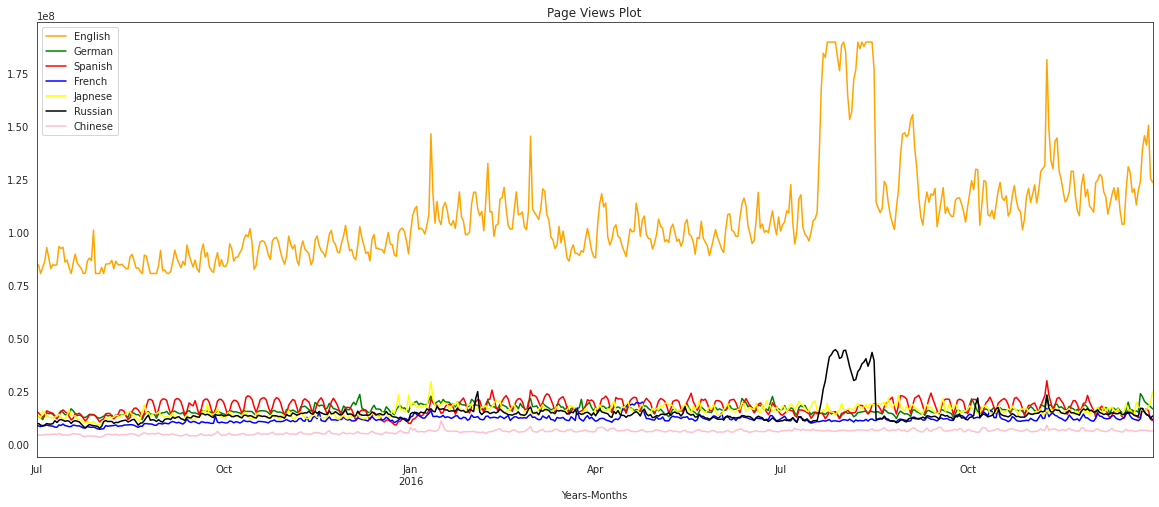

In [ ]:
# Visualizing views of all the pages in different language
  
# using plot method to plot page views.
# in plot method we set the label and color of the curve.
ts['en'].plot(label='English', color='orange')
ts['de'].plot(label='German', color='green')
ts['es'].plot(label='Spanish', color='red')
ts['fr'].plot(label='French', color='blue')
ts['ja'].plot(label='Japnese', color='yellow')
ts['ru'].plot(label='Russian', color='black')
ts['zh'].plot(label='Chinese', color='pink')
# adding title to the plot
plt.title('Page Views Plot')
  
# adding Label to the x-axis
plt.xlabel('Years-Months')
  
# adding legend to the curve
plt.legend()

- **Observation**
  - Most views are for English pages , which are obvious 
  - Least views for chinese pages
  - Russian pages has highest views during August - September 2017 time frame

- What other methods other than grid search would be suitable to get the model for all languages?
  - A popular alternative to grid search would be random search. Random search samples random parameters combinations from a statistical distribution provided by the user. This approach is based on the assumption that in most cases, hyperparameters are not uniformly important.